# European Develompent Indicators - Iceland

## Research Questions

1. How has Iceland's GDP growth correlated with inflation rates over the past 20 years?

2. What is the relationship between educational attainment and unemployment in Iceland?

3. What is the gender wage gap trend in Iceland, and how does it compare with female employment rates?

## Datasets

* [namq_10_gdp](https://doi.org/10.2908/NAMQ_10_GDP) - Eurostat: Quarterly GDP

* [nama_10_co3_p3](https://doi.org/10.2908/NAMA_10_CO3_P3) - Eurostat: Annual household disposable income

* [tec00001](https://doi.org/10.2908/TEC00001) - Eurostat: Annual GDP at market prices

* [prc_hicp_midx](https://doi.org/10.2908/PRC_HICP_MIDX) - Eurostat: Monthly Harmonized CPI

* [prc_hicp_manr](https://doi.org/10.2908/PRC_HICP_MANR) - Eurostat: Monthly CPI inflation rate

* [prc_hicp_inw](https://doi.org/10.2908/PRC_HICP_INW) - Eurostat: Annual CPI inflation rate by income group

* [lfsa_egan](https://doi.org/10.2908/LFSA_EGAN) - Eurostat: Annual employment

* [lfsi_emp_q](https://doi.org/10.2908/LFSI_EMP_Q) - Eurostat: Quarterly employment and activity by sex and age

* [lfsq_ergan](https://doi.org/10.2908/LFSQ_ERGAN) - Eurostat: Quarterly employment rates by citizenship

* [une_rt_m](https://doi.org/10.2908/UNE_RT_M) - Eurostat: Monthly total unemployment rate

* [edat_lfse_03](https://doi.org/10.2908/EDAT_LFSE_03) - Eurostat: Annual population by educational attainment level

* [earn_nt_net](https://doi.org/10.2908/EARN_NT_NET) - Eurostat: Annual net earnings

* [earn_gr_gpgr2](https://doi.org/10.2908/EARN_GR_GPGR2) - Eurostat: Annual gender pay gap in unadjusted form


## Imports

In [21]:
import os
from typing import Literal

import eurostat
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [22]:
COUNTRY_NAME = "Iceland"
COUNTRY_CODE = "IS"

ORIGINAL_DATA_DIR = "original_data"
EVENTS = [
    {
        "name": "2008 Financial Crisis",
        "year": "2008",
        "positive": False
    },
    {
        "name": "EU Membership Application",
        "year": "2009",
        "positive": True
    },
    {
        "name": "Volcanic Eruption Eyjafjallajökull",
        "year": "2010",
        "positive": False
    },
    {
        "name": "Volcanic Eruption Grímsvötn",
        "year": "2011",
        "positive": False
    },
    {
        "name": "COVID-19 Pandemic",
        "year": "2020",
        "positive": False
    }
]

In [23]:
def get_dataframe(eurostat_code: str, country_code: str = COUNTRY_CODE) -> pd.DataFrame:
    file_path = os.path.join(ORIGINAL_DATA_DIR, f"{eurostat_code}.csv")

    if os.path.exists(file_path):
        df = pd.read_csv(file_path)

    else:
        df = eurostat.get_data_df(eurostat_code)
        os.makedirs(ORIGINAL_DATA_DIR, exist_ok=True)
        df.to_csv(file_path, index=False)

    df = df[df["geo\\TIME_PERIOD"] == country_code]
    df.rename(columns={"geo\\TIME_PERIOD": "geo"}, inplace=True)

    return df


In [24]:
def fix_dates(src_df: pd.DataFrame) -> pd.DataFrame:
    df = src_df.copy()

    column_names = df.columns.tolist()
    time_period_index = column_names.index("geo")
    data_columns = column_names[time_period_index + 1 :]

    if df["freq"].iloc[0] == "M":
        df.rename(columns={col: f"{col[:4]}-{col[5:7]}-01" for col in data_columns}, inplace=True)
    elif df["freq"].iloc[0] == "Q":
        df.rename(columns={col: f"{col[:4]}-{(int(col[6]) - 1) * 3 + 1:02d}-01" for col in data_columns}, inplace=True)
    elif df["freq"].iloc[0] == "A":
        df.rename(columns={col: f"{col}-01-01" for col in data_columns}, inplace=True)

    return df


In [25]:
def remove_empty_columns(src_df: pd.DataFrame) -> pd.DataFrame:
    df = src_df.copy()
    df.dropna(axis=1, how="all", inplace=True)

    return df


In [26]:
def melt_dataframe(
    src_df: pd.DataFrame,
) -> pd.DataFrame:
    column_names = src_df.columns.tolist()
    time_period_index = column_names.index("geo")
    data_columns = column_names[time_period_index + 1 :]
    id_cols = column_names[: time_period_index + 1]

    df_melted = src_df.melt(id_vars=id_cols, value_vars=data_columns, var_name="time", value_name="value")
    df_melted = df_melted.drop(columns=["geo"])
    df_melted = df_melted.dropna(subset=["value"])
    df_melted["value"] = pd.to_numeric(df_melted["value"], errors="coerce")

    return df_melted


In [27]:
def drop_columns(src_df: pd.DataFrame, columns_to_drop: list[str]) -> pd.DataFrame:
    df = src_df.copy()
    df.drop(columns=columns_to_drop, inplace=True)

    return df


In [28]:
def filter_dataframe(src_df: pd.DataFrame, filter: dict[str, list[str]]) -> pd.DataFrame:
    df = src_df.copy()

    for column, values in filter.items():
        df = df[df[column].isin(values)]

    return df


In [29]:
def get_unique_values(src_df: pd.DataFrame) -> dict[str, list[str]]:
    df = src_df.copy()
    df = df.drop(columns=["time", "value"]).drop_duplicates()

    unique_values = {col: df[col].unique().tolist() for col in df.columns}

    return unique_values


In [30]:
def make_histogram(
    src_df: pd.DataFrame,
    bins: Literal["auto", "sturges", "fd", "doane", "scott", "rice", "sqrt"] = "auto",
) -> plt.Figure:
    df = src_df.copy()

    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x="value", bins=bins, kde=True)

    plt.title(f"Histogram of {src_df.title}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.grid(True)

    return plt


In [31]:
def make_line_plot(
    src_df: pd.DataFrame,
) -> plt.Figure:
    df = src_df.copy()
    df["time"] = pd.to_datetime(df["time"])

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x="time", y="value")

    for event in EVENTS:
        plt.axvline(pd.to_datetime(f"{event['year']}-01-01"), color='blue' if event['positive'] else 'red', linestyle='--', alpha=0.7)
        plt.text(pd.to_datetime(f"{event['year']}-01-01"), plt.ylim()[1]*0.9, event['name'], rotation=90, verticalalignment='center', color='blue' if event['positive'] else 'red')

    plt.title(f"Line Plot of {src_df.title}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

    return plt


In [32]:
def make_combined_line_plot(
    src_df_1: pd.DataFrame,
    src_df_2: pd.DataFrame
) -> plt.Figure:
    df1 = src_df_1.copy()
    df2 = src_df_2.copy()
    df1["time"] = pd.to_datetime(df1["time"])
    df2["time"] = pd.to_datetime(df2["time"])

    fig, ax1 = plt.subplots(figsize=(12, 6))
    color1 = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel(f'{src_df_1.title}', color=color1)
    ax1.plot(df1['time'], df1['value'], color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()
    color2 = 'tab:orange'
    ax2.set_ylabel(f'{src_df_2.title}', color=color2)
    ax2.plot(df2['time'], df2['value'], color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    plt.title(f"Combined Line Plot of {src_df_1.title} and {src_df_2.title}")
    fig.tight_layout()

    for event in EVENTS:
        plt.axvline(pd.to_datetime(f"{event['year']}-01-01"), color='blue' if event['positive'] else 'red', linestyle='--', alpha=0.7)
        plt.text(pd.to_datetime(f"{event['year']}-01-01"), plt.ylim()[1]*0.9, event['name'], rotation=90, verticalalignment='center', color='blue' if event['positive'] else 'red')

    return plt

In [33]:
def make_scatter_plot(
    src_df: pd.DataFrame,
) -> plt:
    df = src_df.copy()
    df["time"] = pd.to_datetime(df["time"])

    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=df, x="time", y="value")

    for event in EVENTS:
        plt.axvline(pd.to_datetime(f"{event['year']}-01-01"), color='blue' if event['positive'] else 'red', linestyle='--', alpha=0.7)
        plt.text(pd.to_datetime(f"{event['year']}-01-01"), plt.ylim()[1]*0.9, event['name'], rotation=90, verticalalignment='center', color='blue' if event['positive'] else 'red')

    plt.title(f"Scatter Plot of {src_df.title}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

    return plt


In [34]:
def make_box_plot(
    src_df: pd.DataFrame,
) -> plt.Figure:
    df = src_df.copy()
    df["time"] = pd.to_datetime(df["time"])

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x=df["value"])
    plt.xlabel("Value")
    plt.title(f"Box Plot of {src_df.title}")

    return plt

In [35]:
def make_correlation_heatmap(
    dataframes: list[pd.DataFrame],
) -> plt.Figure:
    combined_df = pd.DataFrame()

    for df in dataframes:
        temp_df = df.copy()
        temp_df["time"] = pd.to_datetime(temp_df["time"])
        temp_df.set_index("time", inplace=True)
        temp_df = temp_df.rename(columns={"value": df.name})
        combined_df = pd.concat([combined_df, temp_df[df.name]], axis=1)

    correlation_matrix = combined_df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation Heatmap")

    return plt



In [36]:
def make_combined_bar_plot(
    src_df_1: pd.DataFrame,
    src_df_2: pd.DataFrame
) -> plt.Figure:
    df1 = src_df_1.copy()
    df2 = src_df_2.copy()
    df1["time"] = pd.to_datetime(df1["time"])
    df2["time"] = pd.to_datetime(df2["time"])

    width = (df1['time'].max() - df1['time'].min()).days / len(df1) * 0.5

    fig, ax1 = plt.subplots(figsize=(12, 6))
    color1 = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel(f'{src_df_1.title}', color=color1)
    ax1.bar(df1['time'], df1['value'], color=color1, alpha=0.7, width=width, align='center')
    ax1.tick_params(axis='y', labelcolor=color1)

    ax2 = ax1.twinx()
    color2 = 'tab:orange'
    ax2.set_ylabel(f'{src_df_2.title}', color=color2)
    ax2.bar(df2['time'], df2['value'], color=color2, alpha=0.7, width=width, align='edge')
    ax2.tick_params(axis='y', labelcolor=color2)

    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')

    for event in EVENTS:
        plt.axvline(pd.to_datetime(f"{event['year']}-01-01"), color='blue' if event['positive'] else 'red', linestyle='--', alpha=0.7)
        plt.text(pd.to_datetime(f"{event['year']}-01-01"), plt.ylim()[1]*0.9, event['name'], rotation=90, verticalalignment='center', color='blue' if event['positive'] else 'red')

    plt.title(f"Combined Bar Plot of {src_df_1.title} and {src_df_2.title}")
    fig.tight_layout()

    return plt

In [37]:
def get_change_rates(
    src_df: pd.DataFrame,
) -> pd.DataFrame:
    df = src_df.copy()
    df["time"] = pd.to_datetime(df["time"])
    df = df.sort_values(by="time")
    df["value"] = df["value"].pct_change() * 100

    return df

In [38]:
def combine_to_yearly(
    src_df: pd.DataFrame,
) -> pd.DataFrame:
    df = src_df.copy()
    df = df[["time", "value"]]
    df["time"] = pd.to_datetime(df["time"])
    df = df.set_index("time")

    df_yearly = df.resample('YE').mean().reset_index()
    # df_yearly["time"] = df_yearly["time"].dt.year.astype(str)

    # set the year at the start of the year
    df_yearly["time"] = df_yearly["time"].dt.strftime('%Y-01-01')

    return df_yearly

In [39]:
def get_opposite_trend_data(
    src_df: pd.DataFrame,
) -> pd.DataFrame:
    df = src_df.copy()
    df["value"] = -df["value"]

    return df

In [40]:
def make_combined_similar_line_plot(
    src_df_1: pd.DataFrame,
    src_df_2: pd.DataFrame
) -> plt.Figure:
    df1 = src_df_1.copy()
    df2 = src_df_2.copy()
    df1["time"] = pd.to_datetime(df1["time"])
    df2["time"] = pd.to_datetime(df2["time"])

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df1, x="time", y="value", label=src_df_1.title)
    sns.lineplot(data=df2, x="time", y="value", label=src_df_2.title)

    for event in EVENTS:
        plt.axvline(pd.to_datetime(f"{event['year']}-01-01"), color='blue' if event['positive'] else 'red', linestyle='--', alpha=0.7)
        plt.text(pd.to_datetime(f"{event['year']}-01-01"), plt.ylim()[1]*0.9, event['name'], rotation=90, verticalalignment='center', color='blue' if event['positive'] else 'red')

    plt.title(f"Combined Similar Line Plot of {src_df_1.title} and {src_df_2.title}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)

    return plt

# How has Iceland's GDP growth correlated with inflation rates over the past 20 years?

## Datasets:

* [namq_10_gdp](https://doi.org/10.2908/NAMQ_10_GDP) - Eurostat: Quarterly GDP

* [nama_10_co3_p3](https://doi.org/10.2908/NAMA_10_CO3_P3) - Eurostat: Annual household disposable income

* [tec00001](https://doi.org/10.2908/TEC00001) - Eurostat: Annual GDP at market prices

* [prc_hicp_midx](https://doi.org/10.2908/PRC_HICP_MIDX) - Eurostat: Monthly Harmonized CPI

* [prc_hicp_manr](https://doi.org/10.2908/PRC_HICP_MANR) - Eurostat: Monthly CPI inflation rate

* [prc_hicp_inw](https://doi.org/10.2908/PRC_HICP_INW) - Eurostat: Annual CPI inflation rate by income group


### namq_10_gdp -- Quarterly GDP

`CLV10_MEUR` — Chain linked volumes, base year 2010

`B1GQ` — Gross Domestic Product (GDP), volume, chain-linked, market prices

`SCA` — Seasonally & calendar adjusted


,unit,s_adj,na_item,time,value
95,CLV10_MEUR,SCA,B1GQ,1995-01-01,1578.1
1290,CLV10_MEUR,SCA,B1GQ,1995-04-01,1610.4
2485,CLV10_MEUR,SCA,B1GQ,1995-07-01,1625.4
3680,CLV10_MEUR,SCA,B1GQ,1995-10-01,1613.9
4875,CLV10_MEUR,SCA,B1GQ,1996-01-01,1671.2


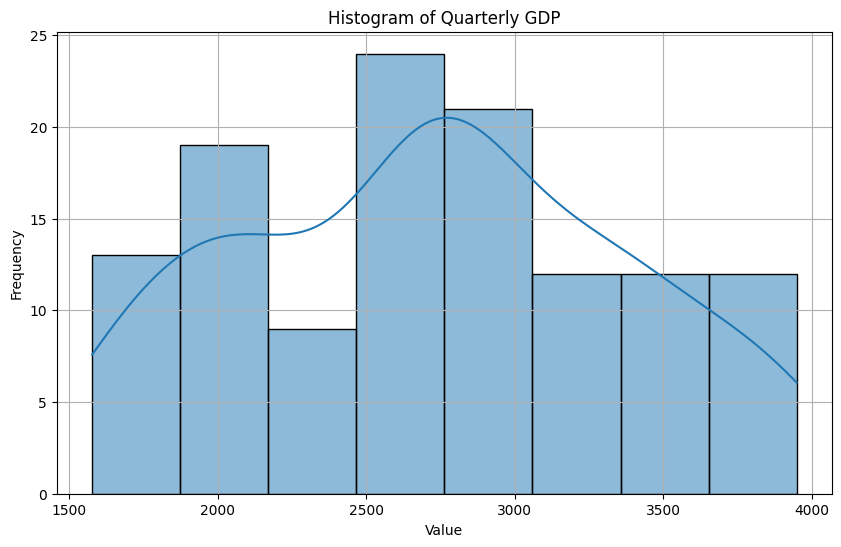

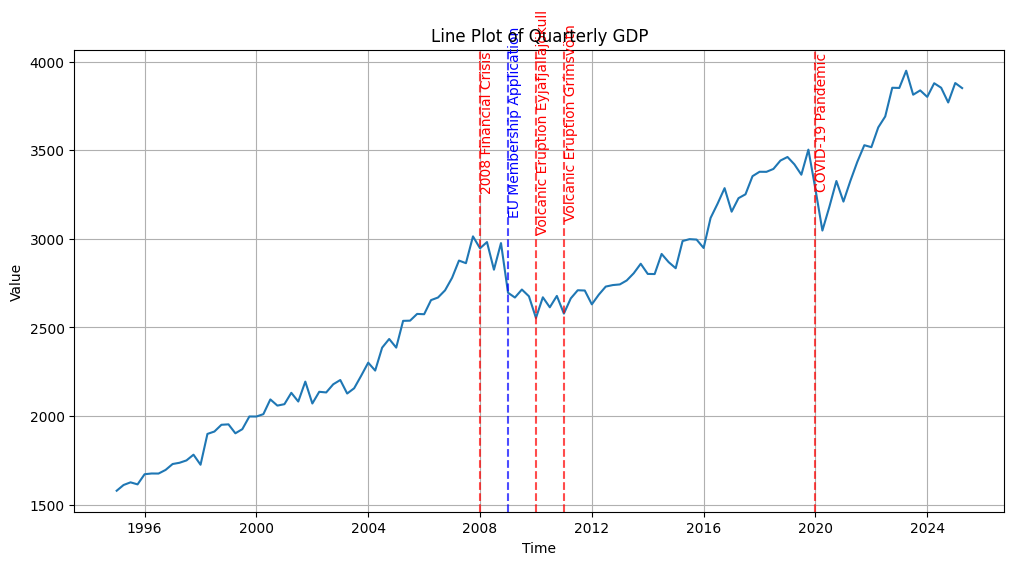

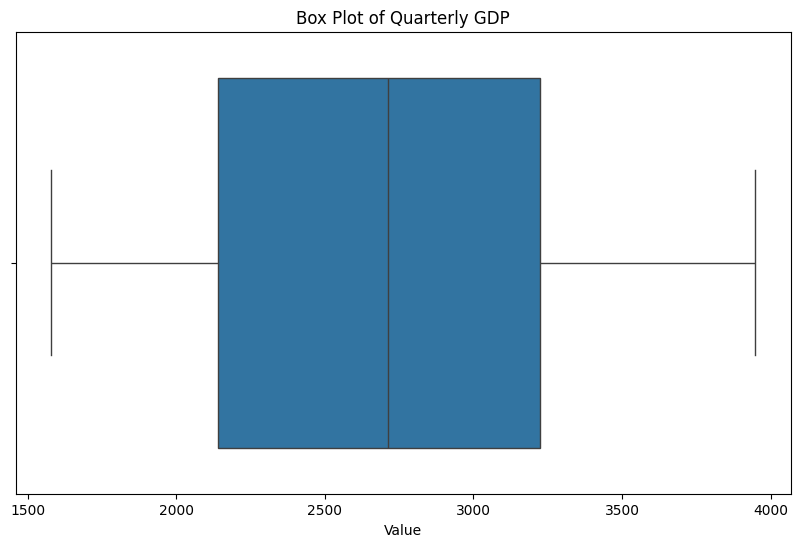

In [830]:
namq_10_gdp = get_dataframe("namq_10_gdp")
namq_10_gdp = fix_dates(namq_10_gdp)
namq_10_gdp = remove_empty_columns(namq_10_gdp)
namq_10_gdp = melt_dataframe(namq_10_gdp)
namq_10_gdp = drop_columns(namq_10_gdp, ["freq"])
namq_10_gdp = filter_dataframe(namq_10_gdp, {"unit": ["CLV10_MEUR"], "na_item": ["B1GQ"], "s_adj": ["SCA"]})
namq_10_gdp.name = "namq_10_gdp"
namq_10_gdp.title = "Quarterly GDP"


display(namq_10_gdp.head())
make_histogram(namq_10_gdp).show()
make_line_plot(namq_10_gdp).show()
# make_scatter_plot(namq_10_gdp).show()
make_box_plot(namq_10_gdp).show()


### nama_10_co3_p3 -- Annual Household Disposable Income

`CLV10_MEUR` — Chain linked volumes, base year 2010

`TOTAL` — Total COICOP


,unit,coicop,time,value
182,CLV10_MEUR,TOTAL,1995-01-01,3208.9
1890,CLV10_MEUR,TOTAL,1996-01-01,3369.0
3598,CLV10_MEUR,TOTAL,1997-01-01,3565.5
5306,CLV10_MEUR,TOTAL,1998-01-01,3951.3
7014,CLV10_MEUR,TOTAL,1999-01-01,4240.4


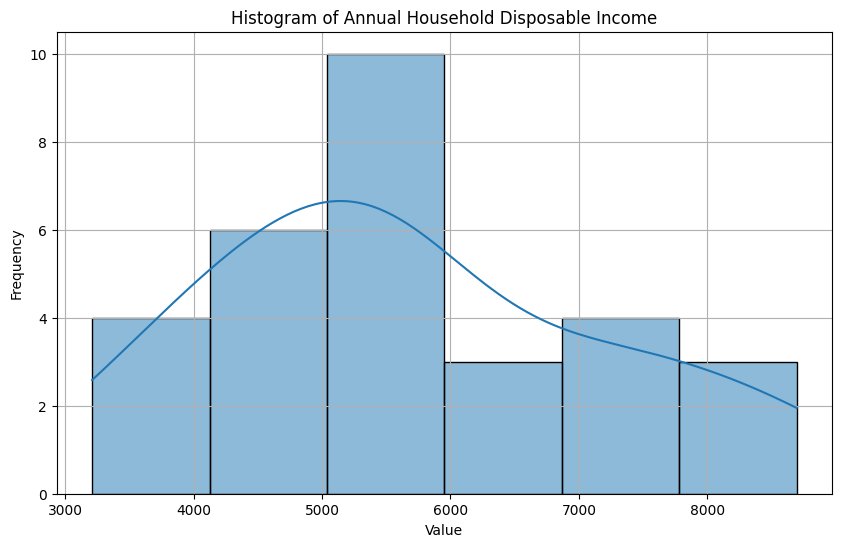

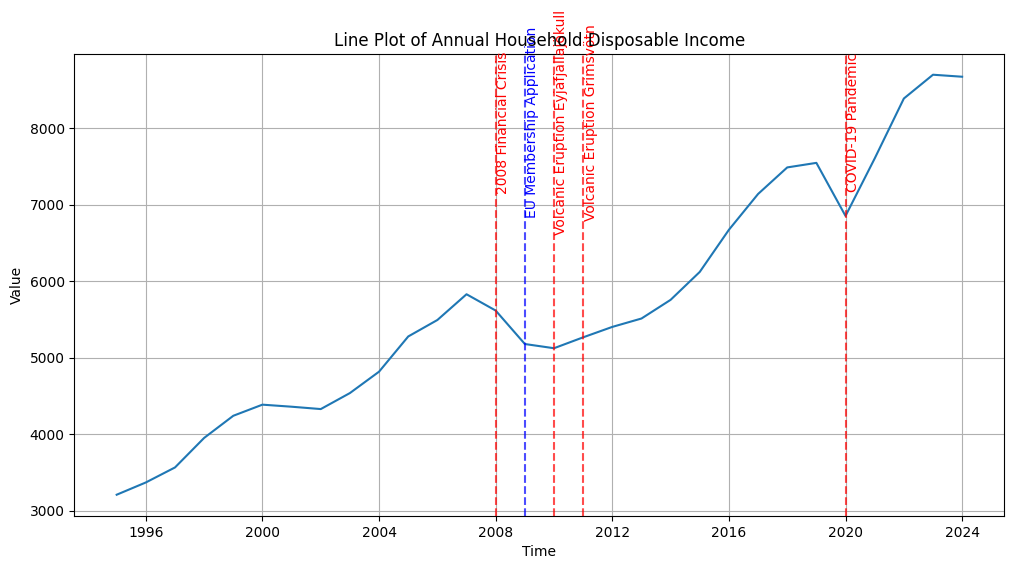

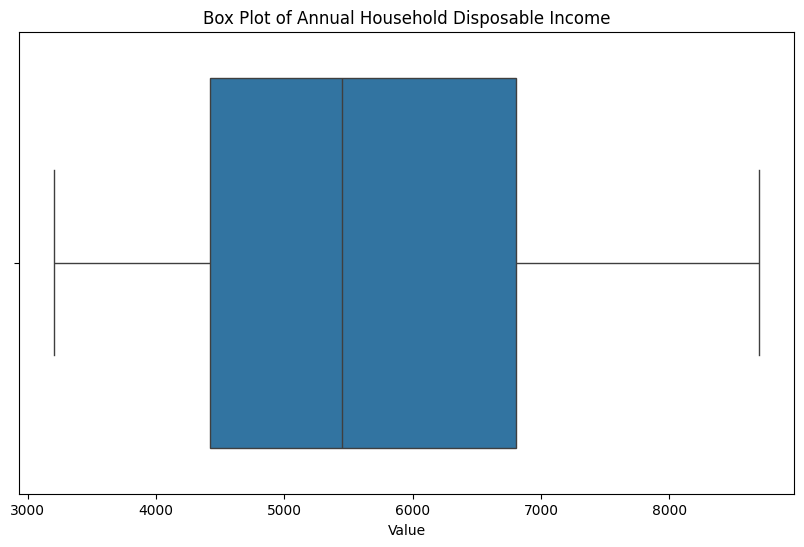

In [831]:
nama_10_co3_p3 = get_dataframe("nama_10_co3_p3")
nama_10_co3_p3 = fix_dates(nama_10_co3_p3)
nama_10_co3_p3 = remove_empty_columns(nama_10_co3_p3)
nama_10_co3_p3 = melt_dataframe(nama_10_co3_p3)
nama_10_co3_p3 = drop_columns(nama_10_co3_p3, ["freq"])
nama_10_co3_p3 = filter_dataframe(nama_10_co3_p3, {"unit": ["CLV10_MEUR"], "coicop": ["TOTAL"]})
nama_10_co3_p3.name = "nama_10_co3_p3"
nama_10_co3_p3.title = "Annual Household Disposable Income"

display(nama_10_co3_p3.head())
make_histogram(nama_10_co3_p3).show()
make_line_plot(nama_10_co3_p3).show()
# make_scatter_plot(nama_10_co3_p3).show()
make_box_plot(nama_10_co3_p3).show()


### tec00001 -- Annual GDP at Market Prices

`CP_MEUR` — Current prices, million euro

`B1GQ` — Gross Domestic Product (GDP), volume, chain-linked, market prices


,na_item,unit,time,value
1,B1GQ,CP_MEUR,2013-01-01,12222.7
3,B1GQ,CP_MEUR,2014-01-01,13611.7
5,B1GQ,CP_MEUR,2015-01-01,15960.5
7,B1GQ,CP_MEUR,2016-01-01,19067.0
9,B1GQ,CP_MEUR,2017-01-01,22211.8


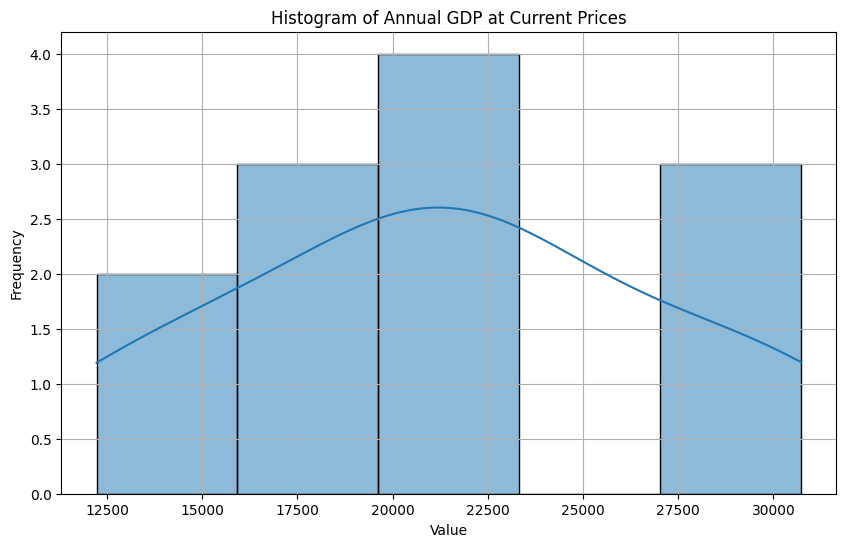

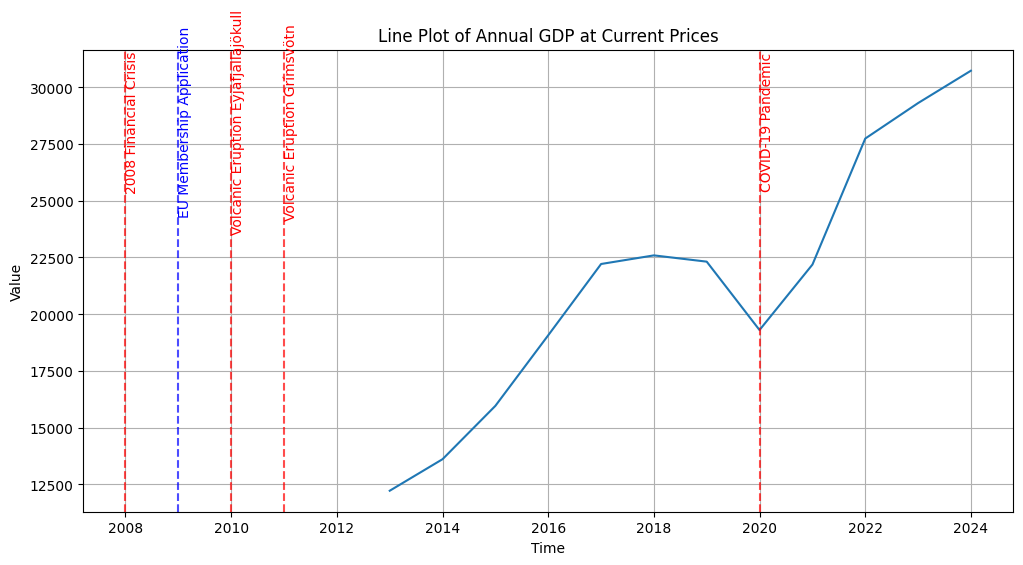

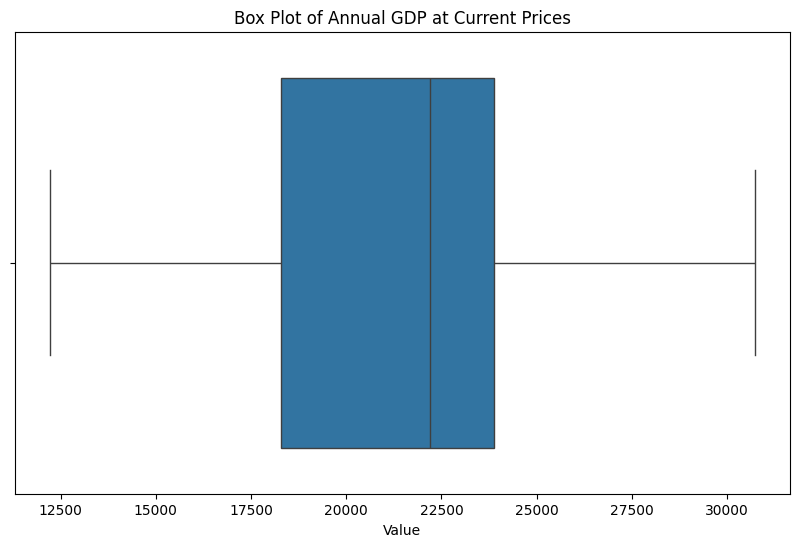

In [832]:
tec00001 = get_dataframe("tec00001")
tec00001 = fix_dates(tec00001)
tec00001 = remove_empty_columns(tec00001)
tec00001 = melt_dataframe(tec00001)
tec00001 = drop_columns(tec00001, ["freq"])
tec00001 = filter_dataframe(tec00001, {"unit": ["CP_MEUR"], "na_item": ["B1GQ"]})
tec00001.name = "tec00001"
tec00001.title = "Annual GDP at Current Prices"

display(tec00001.head())
make_histogram(tec00001).show()
make_line_plot(tec00001).show()
# make_scatter_plot(tec00001).show()
make_box_plot(tec00001).show()


### prc_hicp_midx -- Monthly Harmonized CPI

`I15` - Index, 2015

`CP00` - All-items HICP


,unit,coicop,time,value
156,I15,CP00,1996-01-01,42.75
813,I15,CP00,1996-02-01,42.83
1470,I15,CP00,1996-03-01,42.92
2127,I15,CP00,1996-04-01,43.09
2784,I15,CP00,1996-05-01,43.27


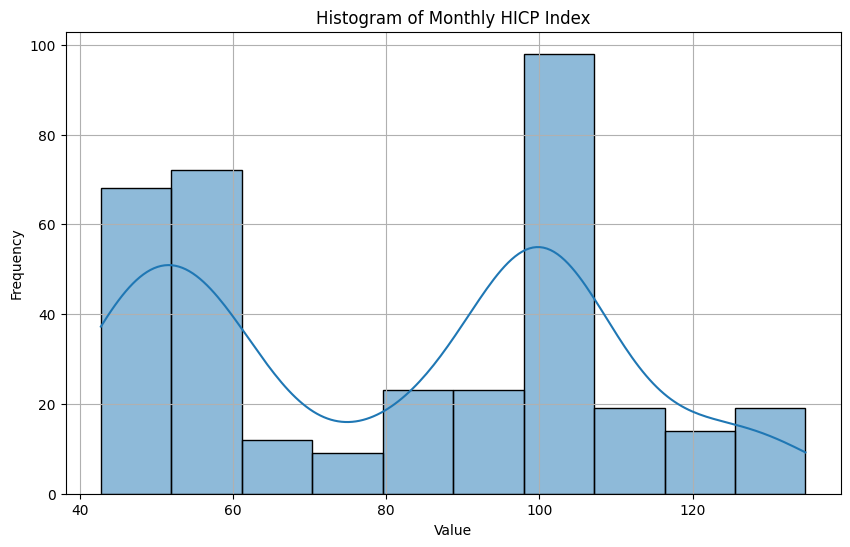

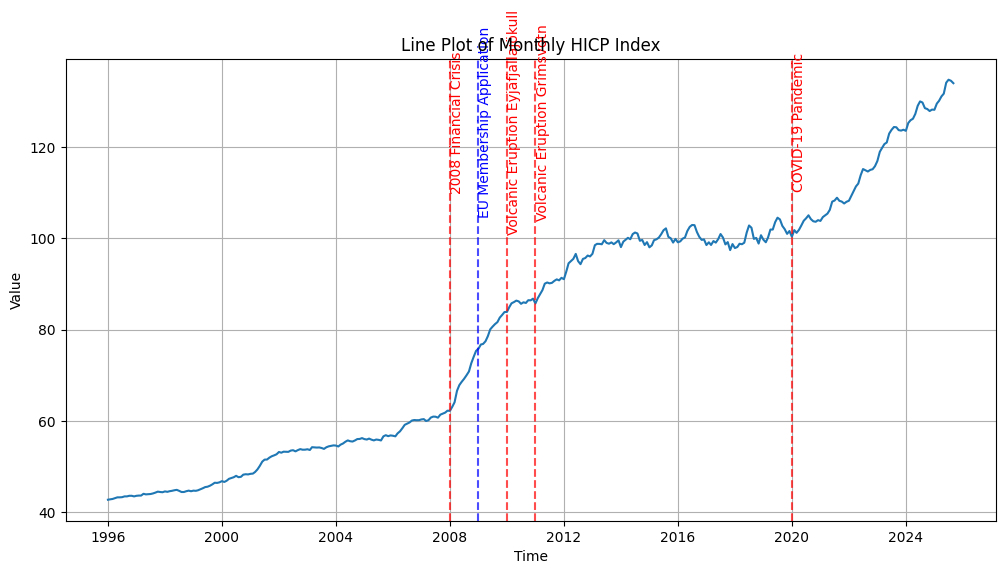

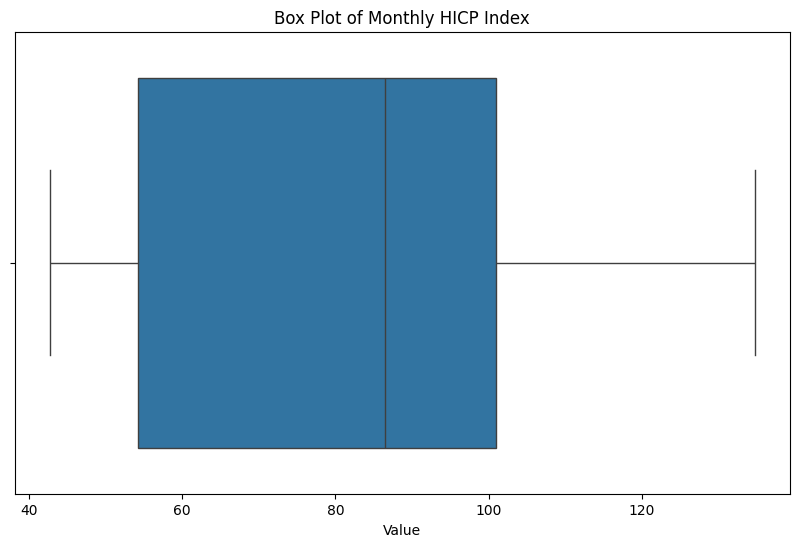

In [833]:
prc_hicp_midx = get_dataframe("prc_hicp_midx")
prc_hicp_midx = fix_dates(prc_hicp_midx)
prc_hicp_midx = remove_empty_columns(prc_hicp_midx)
prc_hicp_midx = melt_dataframe(prc_hicp_midx)
prc_hicp_midx = drop_columns(prc_hicp_midx, ["freq"])
prc_hicp_midx = filter_dataframe(prc_hicp_midx, {"unit": ["I15"], "coicop": ["CP00"]})
prc_hicp_midx.name = "prc_hicp_midx"
prc_hicp_midx.title = "Monthly HICP Index"

display(prc_hicp_midx.head())
make_histogram(prc_hicp_midx).show()
make_line_plot(prc_hicp_midx).show()
# make_scatter_plot(prc_hicp_midx).show()
make_box_plot(prc_hicp_midx).show()


### prc_hicp_manr -- Monthly CPI Inflation Rate

`RCH_A` - Annual rate of change

`CP00` - All-items HICP


,unit,coicop,time,value
0,RCH_A,CP00,1997-01-01,2.0
364,RCH_A,CP00,1997-02-01,1.9
728,RCH_A,CP00,1997-03-01,1.7
1092,RCH_A,CP00,1997-04-01,2.2
1456,RCH_A,CP00,1997-05-01,1.5


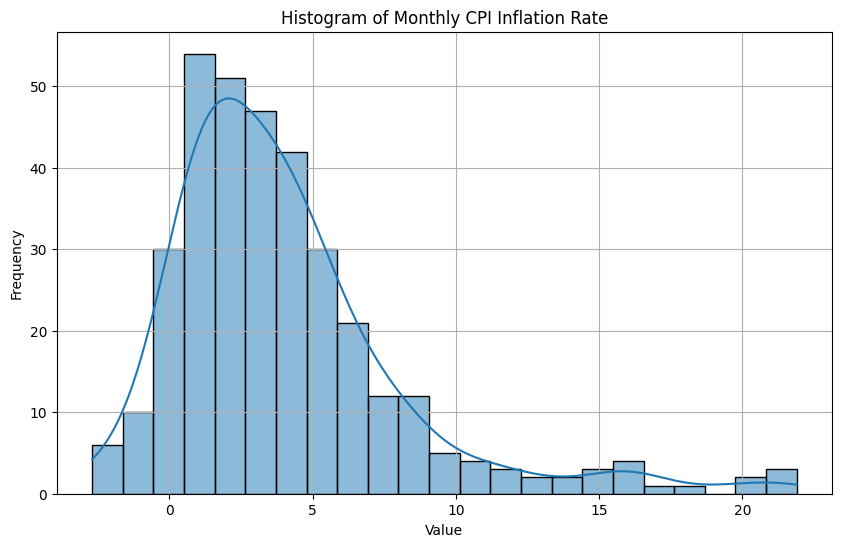

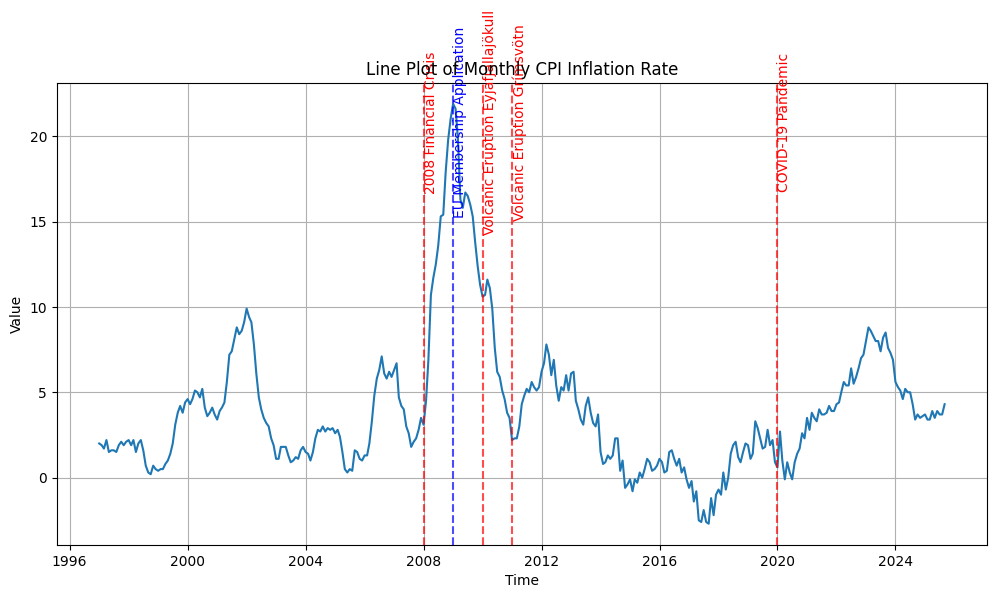

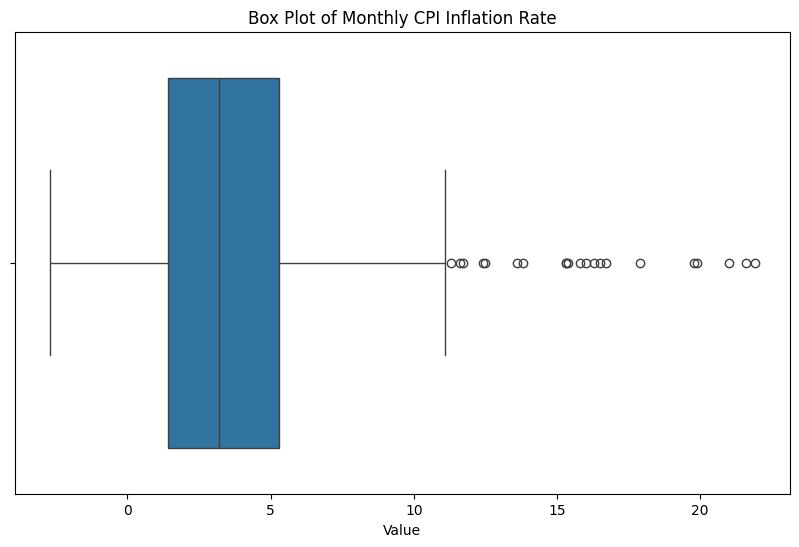

In [834]:
prc_hicp_manr = get_dataframe("prc_hicp_manr")
prc_hicp_manr = fix_dates(prc_hicp_manr)
prc_hicp_manr = remove_empty_columns(prc_hicp_manr)
prc_hicp_manr = melt_dataframe(prc_hicp_manr)
prc_hicp_manr = drop_columns(prc_hicp_manr, ["freq"])
prc_hicp_manr = filter_dataframe(prc_hicp_manr, {"unit": ["RCH_A"], "coicop": ["CP00"]})
prc_hicp_manr.name = "prc_hicp_manr"
prc_hicp_manr.title = "Monthly CPI Inflation Rate"

display(prc_hicp_manr.head())
make_histogram(prc_hicp_manr).show()
make_line_plot(prc_hicp_manr).show()
# make_scatter_plot(prc_hicp_manr).show()
make_box_plot(prc_hicp_manr).show()


### prc_hicp_inw -- Annual CPI Inflation Rate by Income Group

`CP01` - Food and non-alcoholic beverages


,coicop,time,value
3,CP01,1996-01-01,207.70
463,CP01,1997-01-01,206.60
923,CP01,1998-01-01,211.34
1383,CP01,1999-01-01,210.25
1843,CP01,2000-01-01,192.74


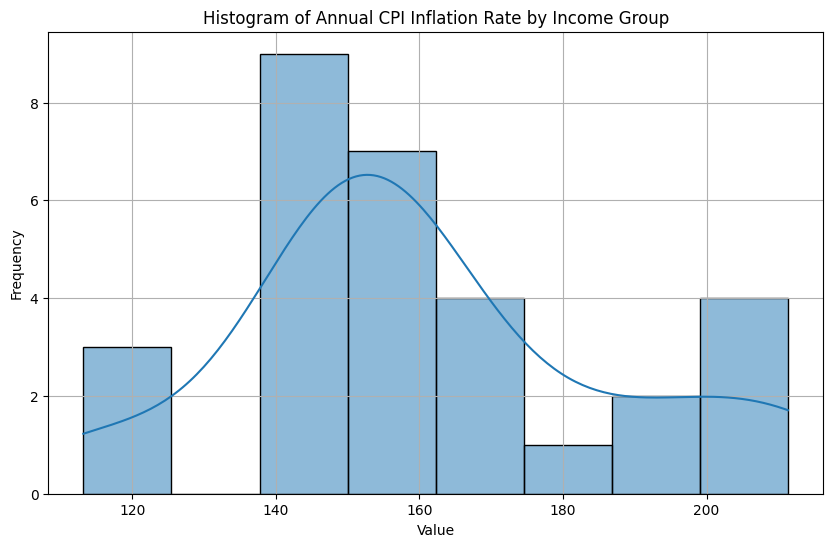

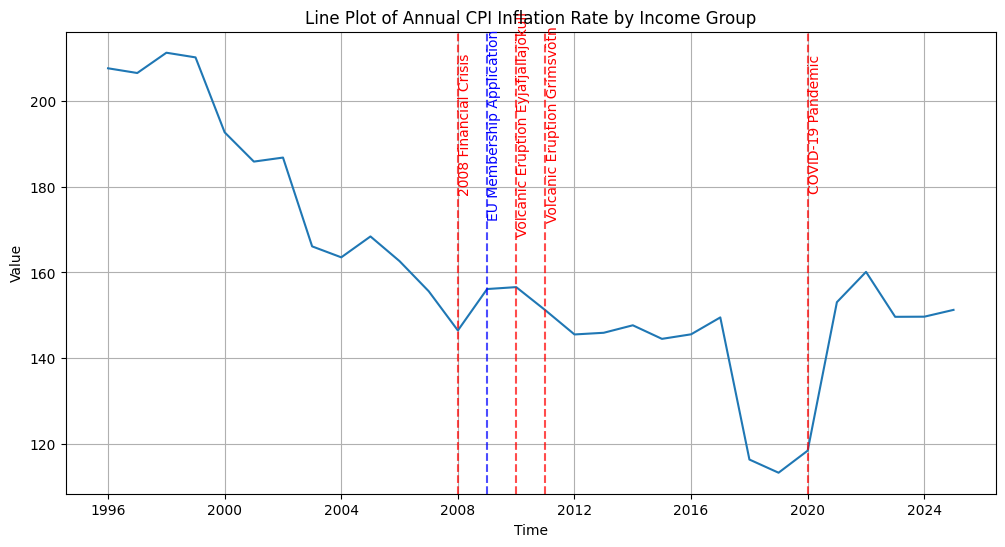

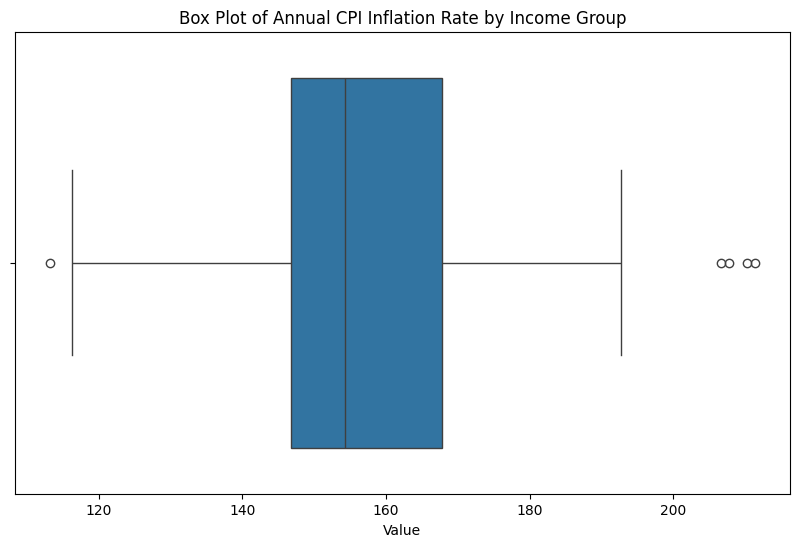

In [835]:
prc_hicp_inw = get_dataframe("prc_hicp_inw")
prc_hicp_inw = fix_dates(prc_hicp_inw)
prc_hicp_inw = remove_empty_columns(prc_hicp_inw)
prc_hicp_inw = melt_dataframe(prc_hicp_inw)
prc_hicp_inw = drop_columns(prc_hicp_inw, ["freq"])
prc_hicp_inw = filter_dataframe(prc_hicp_inw, {"coicop": ["CP01"]})
prc_hicp_inw.name = "prc_hicp_inw"
prc_hicp_inw.title = "Annual CPI Inflation Rate by Income Group"

display(prc_hicp_inw.head())
make_histogram(prc_hicp_inw).show()
make_line_plot(prc_hicp_inw).show()
# make_scatter_plot(prc_hicp_inw).show()
make_box_plot(prc_hicp_inw).show()


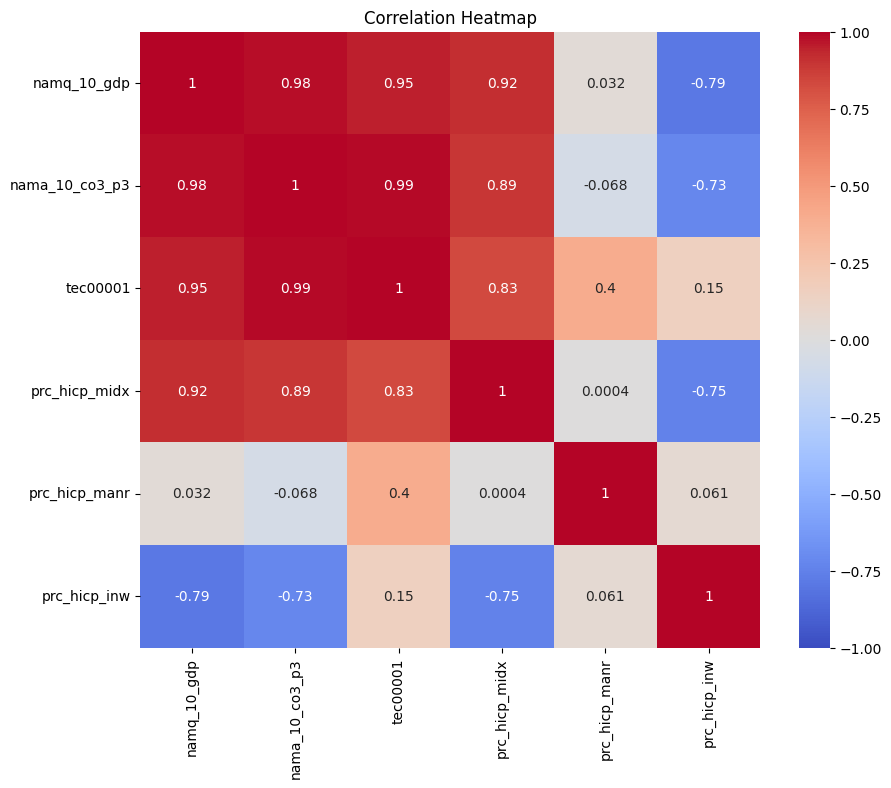

In [836]:
make_correlation_heatmap([
    namq_10_gdp,
    nama_10_co3_p3,
    tec00001,
    prc_hicp_midx,
    prc_hicp_manr,
    prc_hicp_inw
]).show()

In [837]:
display(namq_10_gdp.title)
display(nama_10_co3_p3.title)
display(tec00001.title)
display(prc_hicp_midx.title)
display(prc_hicp_manr.title)
display(prc_hicp_inw.title)

'Quarterly GDP'

'Annual Household Disposable Income'

'Annual GDP at Current Prices'

'Monthly HICP Index'

'Monthly CPI Inflation Rate'

'Annual CPI Inflation Rate by Income Group'

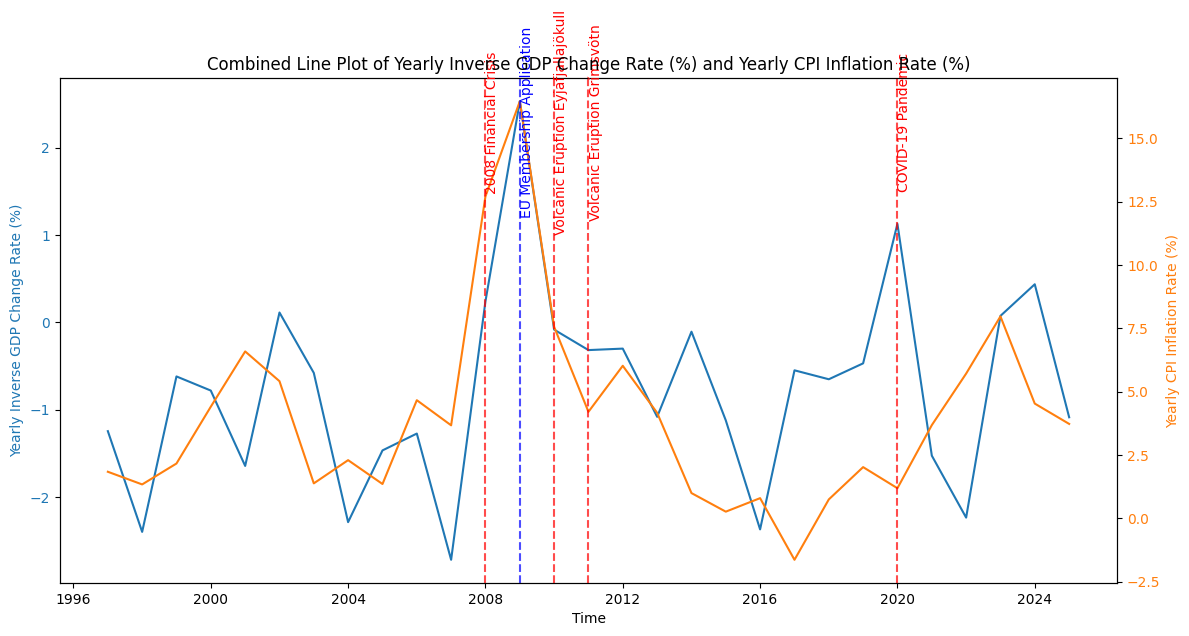

'Correlation Coefficient between Inverse GDP Change Rate and CPI Inflation Rate: 0.504996372728071'

In [838]:
namq_10_gdp_changes_y_inverse = get_opposite_trend_data(combine_to_yearly(get_change_rates(namq_10_gdp)))
prc_hicp_manr_yearly = combine_to_yearly(prc_hicp_manr)

# trim so both have same time range
start_date = max(namq_10_gdp_changes_y_inverse["time"].min(), prc_hicp_manr_yearly["time"].min())
end_date = min(namq_10_gdp_changes_y_inverse["time"].max(), prc_hicp_manr_yearly["time"].max())
namq_10_gdp_changes_y_inverse = namq_10_gdp_changes_y_inverse[
    (namq_10_gdp_changes_y_inverse["time"] >= start_date) &
    (namq_10_gdp_changes_y_inverse["time"] <= end_date)
]
prc_hicp_manr_yearly = prc_hicp_manr_yearly[
    (prc_hicp_manr_yearly["time"] >= start_date) &
    (prc_hicp_manr_yearly["time"] <= end_date)
]

namq_10_gdp_changes_y_inverse.title = "Yearly Inverse GDP Change Rate (%)"
namq_10_gdp_changes_y_inverse.name = "Yearly Inverse GDP Change Rate (%)"
prc_hicp_manr_yearly.title = "Yearly CPI Inflation Rate (%)"
prc_hicp_manr_yearly.name = "Yearly CPI Inflation Rate (%)"

make_combined_line_plot(
    namq_10_gdp_changes_y_inverse,
    prc_hicp_manr_yearly
).show()

# get correlation coefficient
correlation_df = pd.merge(
    namq_10_gdp_changes_y_inverse,
    prc_hicp_manr_yearly,
    on="time",
    suffixes=("_gdp", "_inflation")
)
correlation_coefficient = correlation_df["value_gdp"].corr(correlation_df["value_inflation"])
display(f"Correlation Coefficient between Inverse GDP Change Rate and CPI Inflation Rate: {correlation_coefficient}")


Conclusion: Iceland's GDP growth is inversely correlated with inflation rates over the past 20 years, as evidenced by a correlation coefficient of 50.5%.

# What is the relationship between educational attainment and unemployment in Iceland?

## Datasets:

* [lfsa_egan](https://doi.org/10.2908/LFSA_EGAN) - Eurostat: Annual employment

* [lfsq_ergan](https://doi.org/10.2908/LFSQ_ERGAN) - Eurostat: Quarterly employment rates by citizenship

* [une_rt_m](https://doi.org/10.2908/UNE_RT_M) - Eurostat: Monthly total unemployment rate

* [edat_lfse_03](https://doi.org/10.2908/EDAT_LFSE_03) - Eurostat: Annual population by educational attainment level


### lfsa_egan -- Annual Employment

`THS_PER` - Thousands of persons

`T` - Total

`Y15-64` - Age 15-64

`TOTAL` - Total


,unit,sex,age,citizen,time,value
439,THS_PER,T,Y15-64,TOTAL,1995-01-01,132.5
1058,THS_PER,T,Y15-64,TOTAL,1996-01-01,133.0
1677,THS_PER,T,Y15-64,TOTAL,1997-01-01,132.2
2296,THS_PER,T,Y15-64,TOTAL,1998-01-01,137.7
2915,THS_PER,T,Y15-64,TOTAL,1999-01-01,143.7


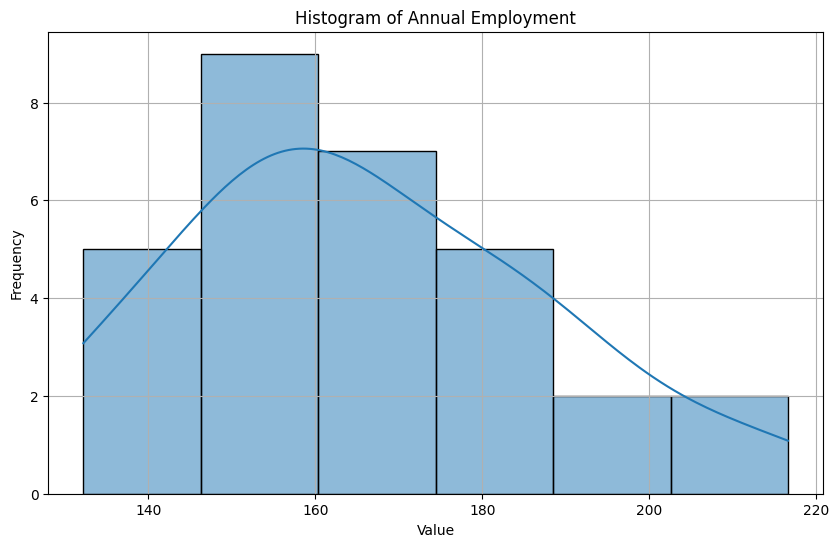

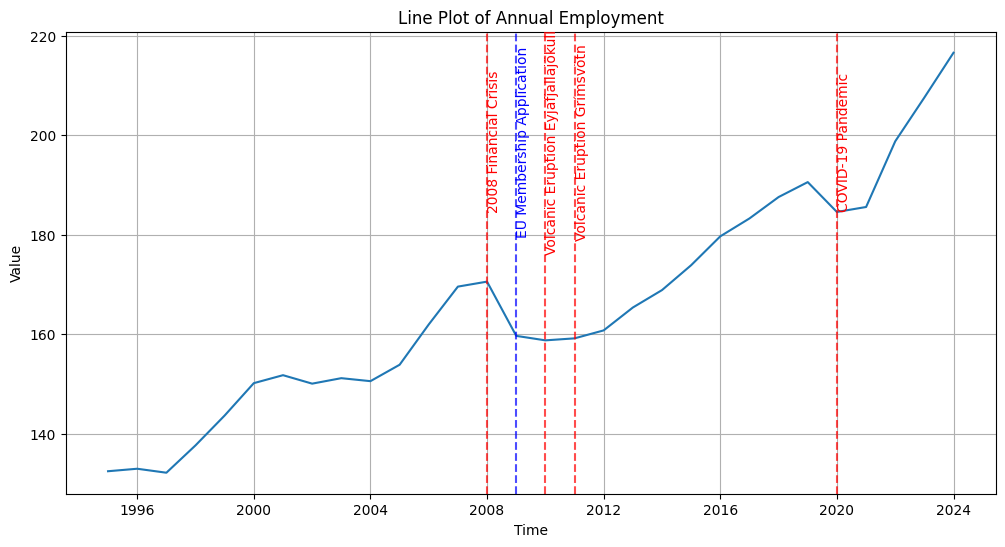

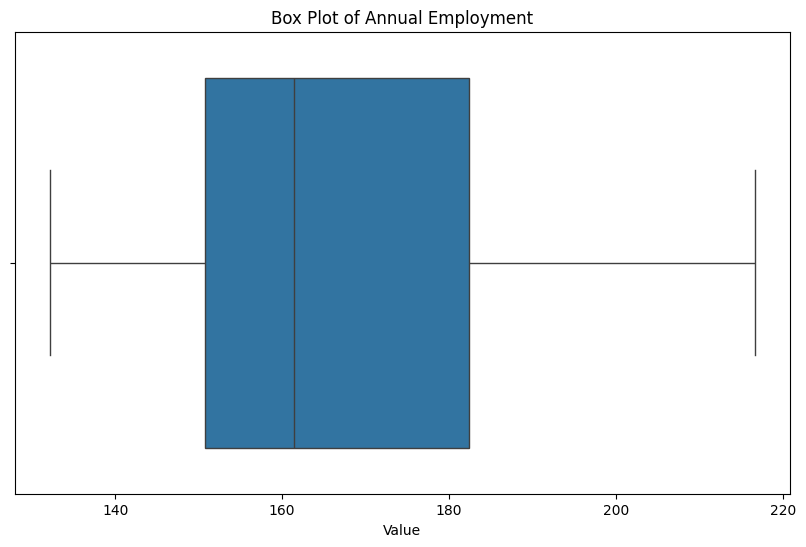

In [839]:
lfsa_egan = get_dataframe("lfsa_egan")
lfsa_egan = fix_dates(lfsa_egan)
lfsa_egan = remove_empty_columns(lfsa_egan)
lfsa_egan = melt_dataframe(lfsa_egan)
lfsa_egan = drop_columns(lfsa_egan, ["freq"])
lfsa_egan = filter_dataframe(lfsa_egan, {"unit": ["THS_PER"], "age": ["Y15-64"], "sex": ["T"], "citizen": ["TOTAL"]})
lfsa_egan.name = "lfsa_egan"
lfsa_egan.title = "Annual Employment"

display(lfsa_egan.head())
make_histogram(lfsa_egan).show()
make_line_plot(lfsa_egan).show()
# make_scatter_plot(lfsa_egan).show()
make_box_plot(lfsa_egan).show()

### lfsq_ergan -- Quarterly Employment Rates by Citizenship

`T` - Total

`Y15-64` - Age 15-64

`TOTAL` - Total


,unit,sex,age,citizen,time,value
464,PC,T,Y15-64,TOTAL,1998-04-01,83.1
1119,PC,T,Y15-64,TOTAL,1999-04-01,85.4
1774,PC,T,Y15-64,TOTAL,2000-04-01,87.1
2429,PC,T,Y15-64,TOTAL,2001-04-01,86.9
3084,PC,T,Y15-64,TOTAL,2002-04-01,85.0


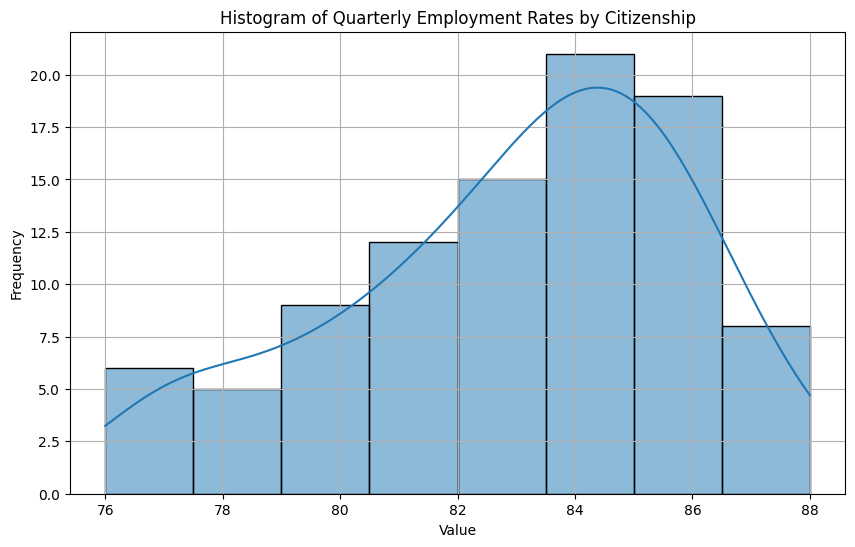

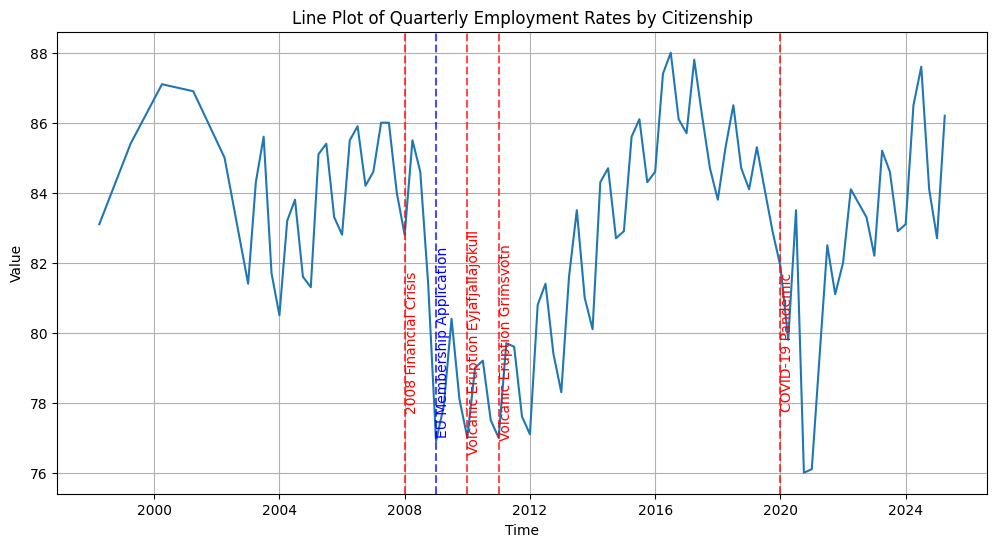

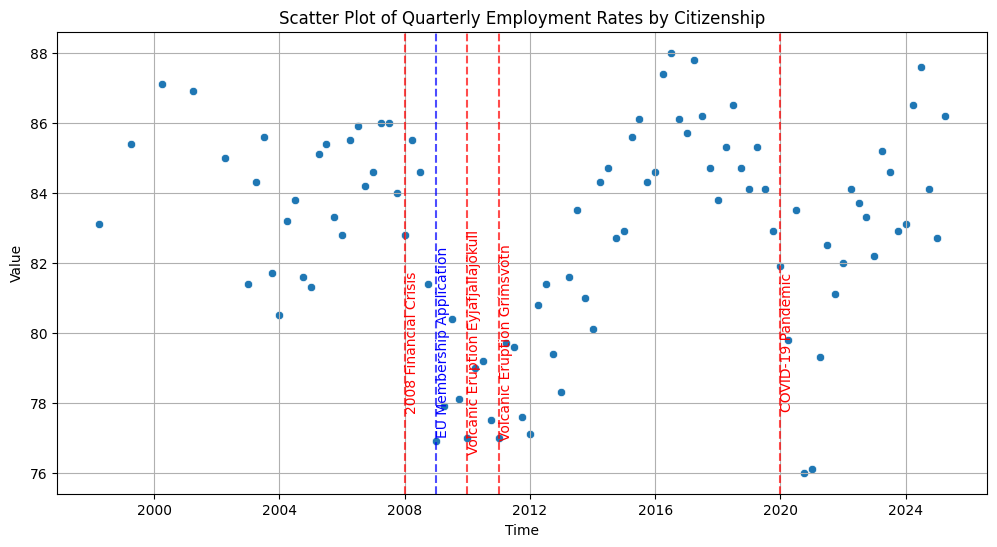

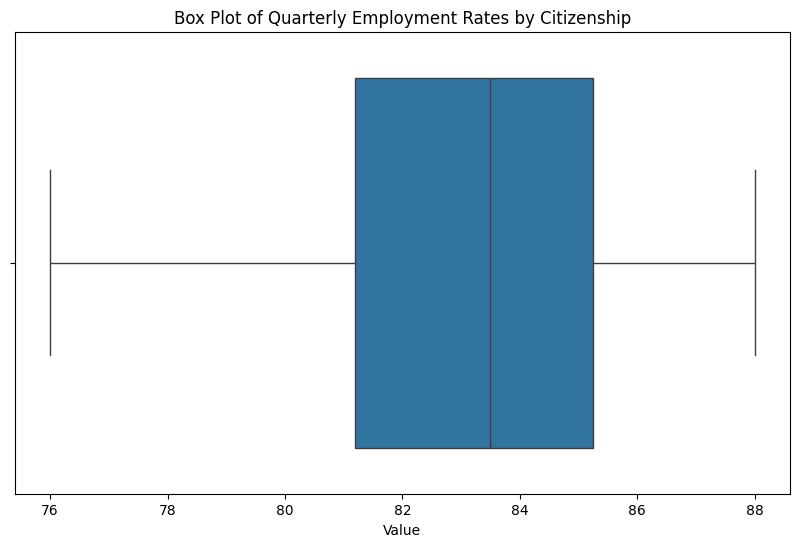

In [840]:
lfsq_ergan = get_dataframe("lfsq_ergan")
lfsq_ergan = fix_dates(lfsq_ergan)
lfsq_ergan = remove_empty_columns(lfsq_ergan)
lfsq_ergan = melt_dataframe(lfsq_ergan)
lfsq_ergan = drop_columns(lfsq_ergan, ["freq"])
lfsq_ergan = filter_dataframe(lfsq_ergan, {"sex": ["T"], "age": ["Y15-64"], "citizen": ["TOTAL"]})
lfsq_ergan.name = "lfsq_ergan"
lfsq_ergan.title = "Quarterly Employment Rates by Citizenship"

display(lfsq_ergan.head())
make_histogram(lfsq_ergan).show()
make_line_plot(lfsq_ergan).show()
make_scatter_plot(lfsq_ergan).show()
make_box_plot(lfsq_ergan).show()


### une_rt_m -- Monthly Total Unemployment Rate

`SA` - Seasonally adjusted

`TOTAL` - Total

`PC_ACT` - Percentage of active population

`T` - Total


,s_adj,age,unit,sex,time,value
20,SA,TOTAL,PC_ACT,T,2003-01-01,3.8
74,SA,TOTAL,PC_ACT,T,2003-02-01,3.7
128,SA,TOTAL,PC_ACT,T,2003-03-01,3.6
182,SA,TOTAL,PC_ACT,T,2003-04-01,3.6
236,SA,TOTAL,PC_ACT,T,2003-05-01,3.5


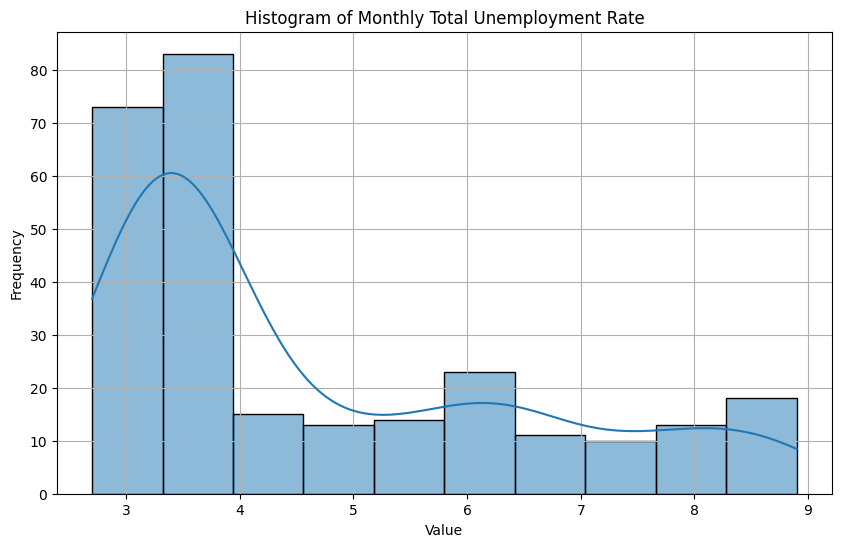

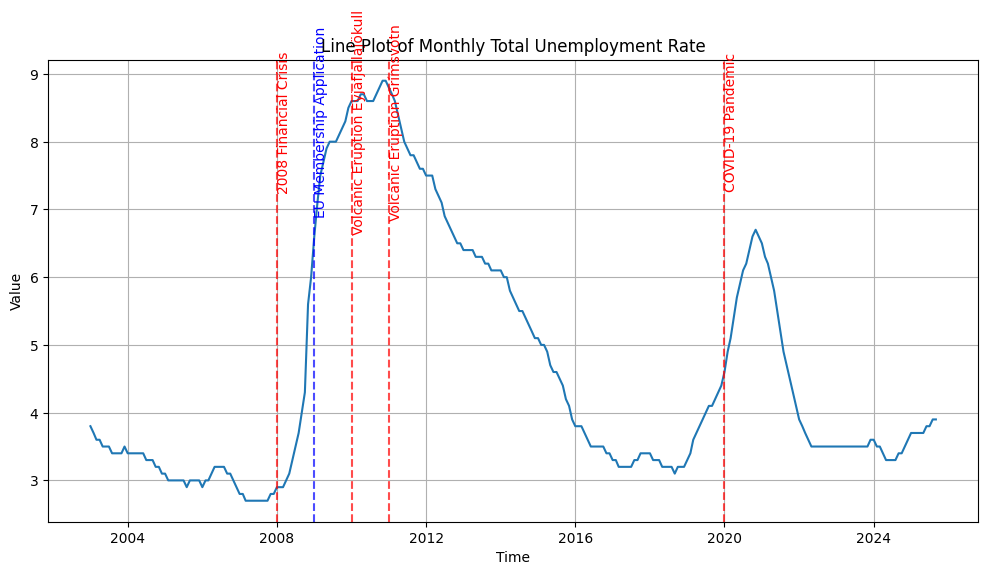

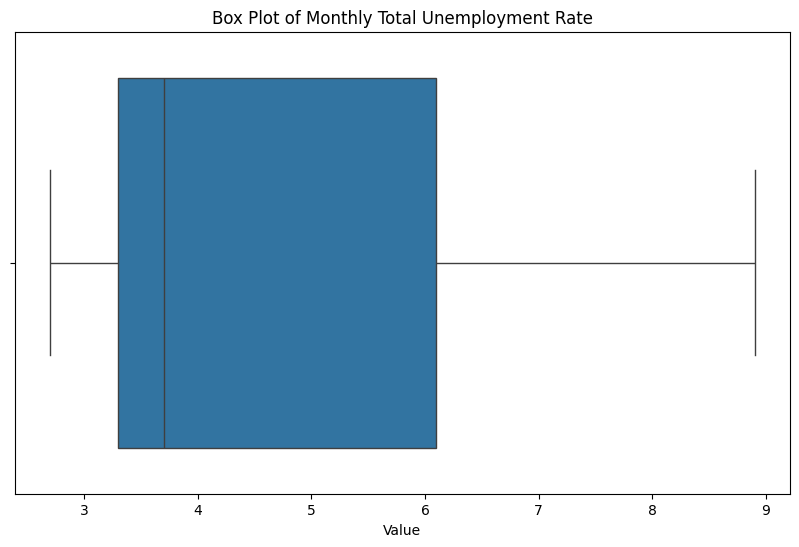

In [841]:
une_rt_m = get_dataframe("une_rt_m")
une_rt_m = fix_dates(une_rt_m)
une_rt_m = remove_empty_columns(une_rt_m)
une_rt_m = melt_dataframe(une_rt_m)
une_rt_m = drop_columns(une_rt_m, ["freq"])
une_rt_m = filter_dataframe(une_rt_m, {"sex": ["T"], "age": ["TOTAL"], "s_adj": ["SA"], "unit": ["PC_ACT"]})
une_rt_m.name = "une_rt_m"
une_rt_m.title = "Monthly Total Unemployment Rate"

display(une_rt_m.head())
make_histogram(une_rt_m).show()
make_line_plot(une_rt_m).show()
# make_scatter_plot(une_rt_m).show()
make_box_plot(une_rt_m).show()


### edat_lfse_03 -- Annual Population by Educational Attainment Level

`T` - Total

`Y15-64` - Age group 15-64

`ED5-8` - Tertiary education (levels 5 to 8)


,sex,age,unit,isced11,time,value
125,T,Y15-64,PC,ED5-8,1999-01-01,17.5
305,T,Y15-64,PC,ED5-8,2000-01-01,19.0
485,T,Y15-64,PC,ED5-8,2001-01-01,19.1
665,T,Y15-64,PC,ED5-8,2002-01-01,20.6
845,T,Y15-64,PC,ED5-8,2003-01-01,23.4


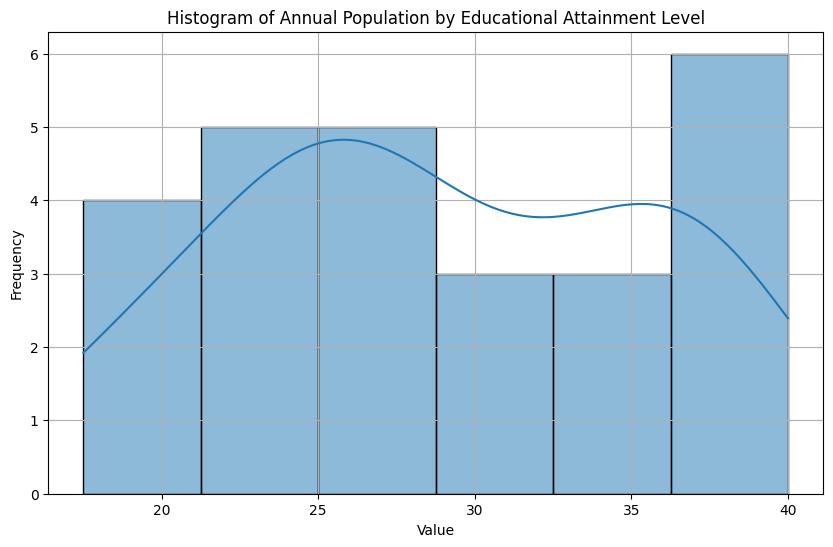

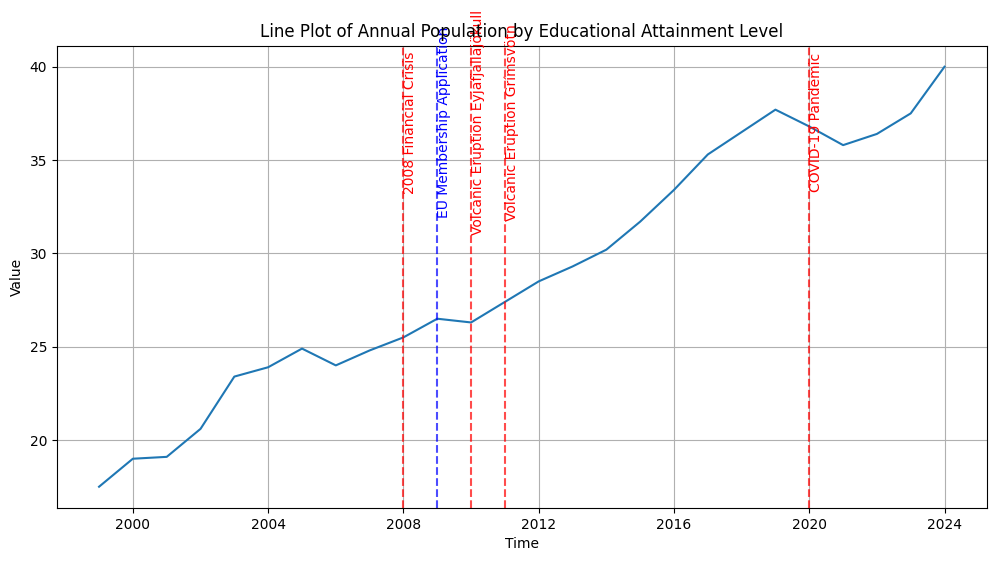

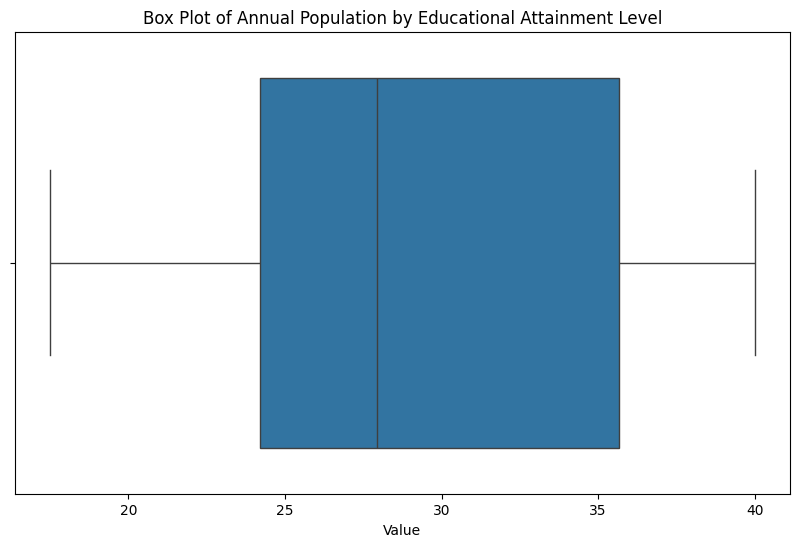

In [842]:
edat_lfse_03 = get_dataframe("edat_lfse_03")
edat_lfse_03 = fix_dates(edat_lfse_03)
edat_lfse_03 = remove_empty_columns(edat_lfse_03)
edat_lfse_03 = melt_dataframe(edat_lfse_03)
edat_lfse_03 = drop_columns(edat_lfse_03, ["freq"])
edat_lfse_03 = filter_dataframe(edat_lfse_03, {"sex": ["T"], "age": ["Y15-64"], "isced11": ["ED5-8"], "unit": ["PC"]})
edat_lfse_03.name = "edat_lfse_03"
edat_lfse_03.title = "Annual Population by Educational Attainment Level"

display(edat_lfse_03.head())
make_histogram(edat_lfse_03).show()
make_line_plot(edat_lfse_03).show()
# make_scatter_plot(edat_lfse_03).show()
make_box_plot(edat_lfse_03).show()


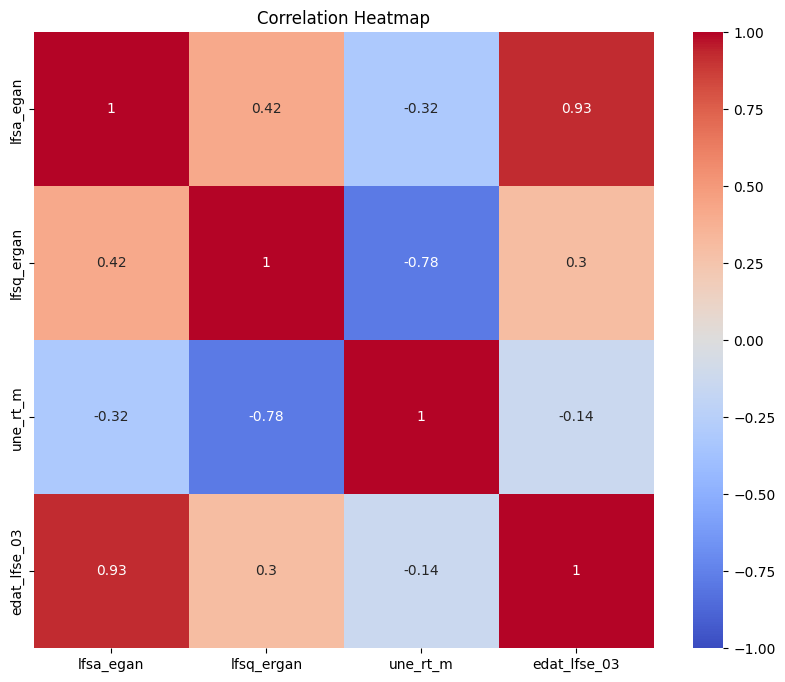

In [843]:
make_correlation_heatmap([
    lfsa_egan,
    lfsq_ergan,
    une_rt_m,
    edat_lfse_03
]).show()

In [844]:
display(lfsa_egan.title)
display(lfsq_ergan.title)
display(une_rt_m.title)
display(edat_lfse_03.title)

'Annual Employment'

'Quarterly Employment Rates by Citizenship'

'Monthly Total Unemployment Rate'

'Annual Population by Educational Attainment Level'

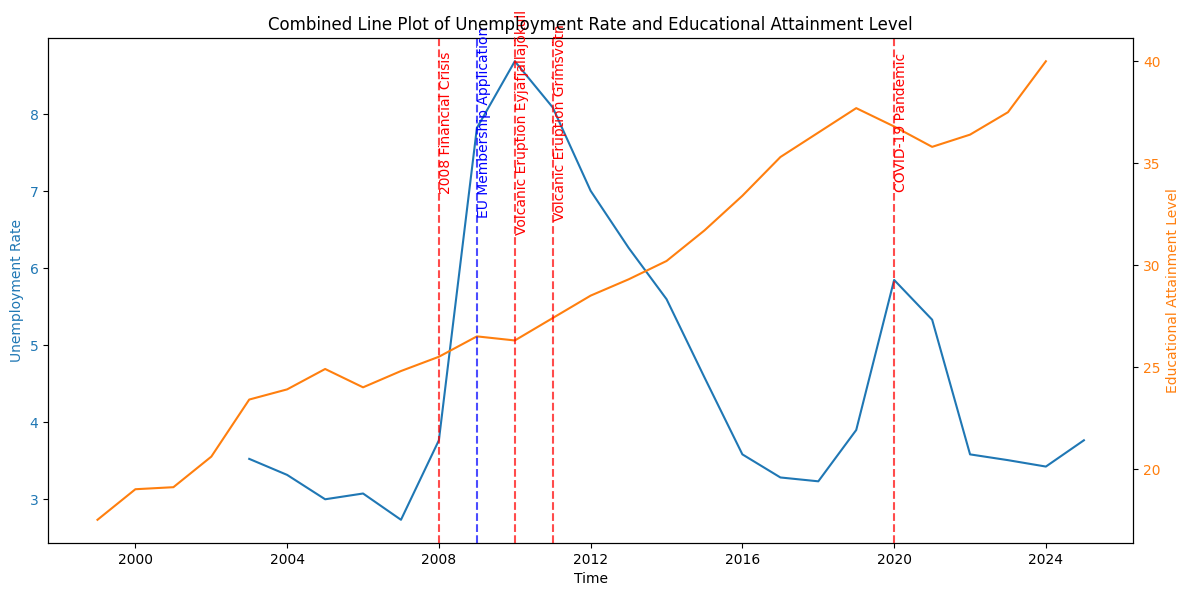

'Correlation Coefficient between Unemployment Rate and Educational Attainment Level: -0.16074988686876682'

In [845]:
une_rt_m_yearly = combine_to_yearly(une_rt_m)
edat_lfse_03_yearly = combine_to_yearly(edat_lfse_03)

une_rt_m_yearly.name = "une_rt_m_yearly"
une_rt_m_yearly.title = "Unemployment Rate"
edat_lfse_03_yearly.name = "edat_lfse_03_yearly"
edat_lfse_03_yearly.title = "Educational Attainment Level"

make_combined_line_plot(
    une_rt_m_yearly,
    edat_lfse_03_yearly
).show()

correlation_df = pd.merge(
    une_rt_m_yearly,
    edat_lfse_03_yearly,
    on="time",
    suffixes=("_unemployment", "_education")
)
correlation_coefficient = correlation_df["value_unemployment"].corr(correlation_df["value_education"])
display(f"Correlation Coefficient between Unemployment Rate and Educational Attainment Level: {correlation_coefficient}")


Conclusion: There is no proof of correlation between educational attainment and unemployment in Iceland based on the analyzed datasets due to a correlation coefficient of -16%.

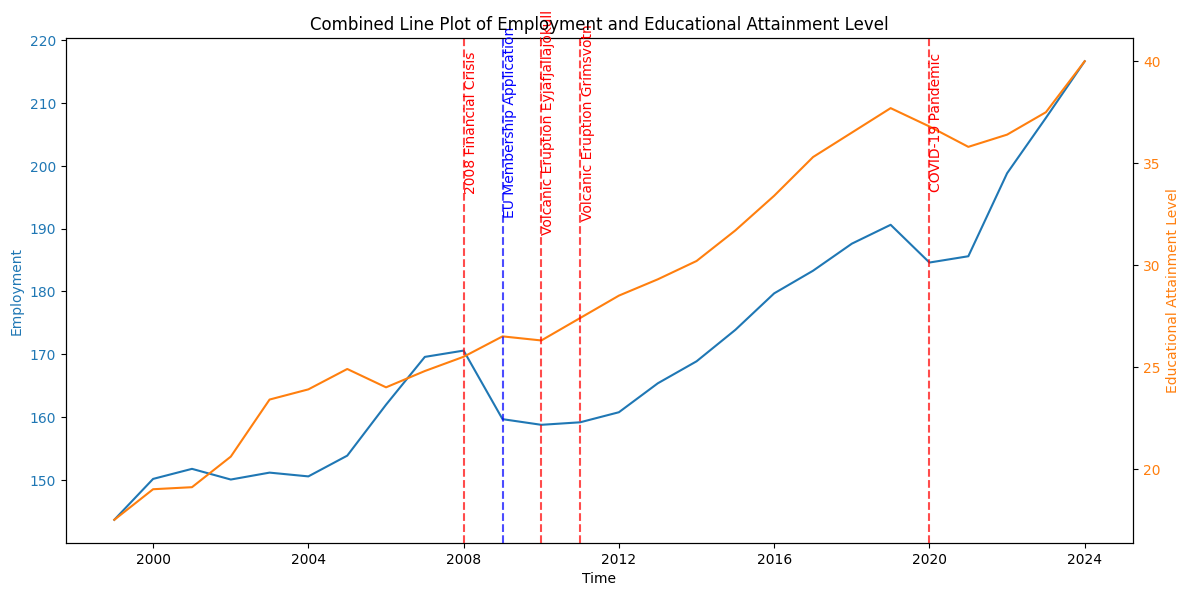

'Correlation Coefficient between Employment and Educational Attainment Level: 0.9259511994557452'

In [846]:
start_date = max(lfsa_egan["time"].min(), edat_lfse_03["time"].min())
end_date = min(lfsa_egan["time"].max(), edat_lfse_03["time"].max())
lfsa_egan_l = lfsa_egan[
    (lfsa_egan["time"] >= start_date) &
    (lfsa_egan["time"] <= end_date)
]
edat_lfse_03_l = edat_lfse_03[
    (edat_lfse_03["time"] >= start_date) &
    (edat_lfse_03["time"] <= end_date)
]

lfsa_egan_l.name = "lfsa_egan_l"
lfsa_egan_l.title = "Employment"
edat_lfse_03_l.name = "edat_lfse_03_l"
edat_lfse_03_l.title = "Educational Attainment Level"

make_combined_line_plot(
    lfsa_egan_l,
    edat_lfse_03_l
).show()

correlation_df = pd.merge(
    lfsa_egan,
    edat_lfse_03,
    on="time",
    suffixes=("_employment", "_education")
)
correlation_coefficient = correlation_df["value_employment"].corr(correlation_df["value_education"])
display(f"Correlation Coefficient between Employment and Educational Attainment Level: {correlation_coefficient}")

Conclusion: There is a significant relationship between educational attainment and employment in Iceland, with a correlation coefficient of 92.6%.

# What is the gender wage gap trend in Iceland, and how does it compare with female employment rates?

## Datasets:


* [lfsa_egan](https://doi.org/10.2908/LFSA_EGAN) - Eurostat: Annual employment

* [earn_gr_gpgr2](https://doi.org/10.2908/EARN_GR_GPGR2) - Eurostat: Annual gender pay gap in unadjusted form

* [earn_nt_net](https://doi.org/10.2908/EARN_NT_NET) - Eurostat: Annual net earnings


### lfsa_egan -- Annual Employment

`THS_PER` - Thousands of persons

`M` - Male

`F` - Female

`T` - Total

`Y15-64` - Age 15-64

`TOTAL` - Total


,unit,sex,age,citizen,time,value
32,THS_PER,F,Y15-64,TOTAL,1995-01-01,62.7
651,THS_PER,F,Y15-64,TOTAL,1996-01-01,62.3
1270,THS_PER,F,Y15-64,TOTAL,1997-01-01,61.5
1889,THS_PER,F,Y15-64,TOTAL,1998-01-01,64.1
2508,THS_PER,F,Y15-64,TOTAL,1999-01-01,67.3


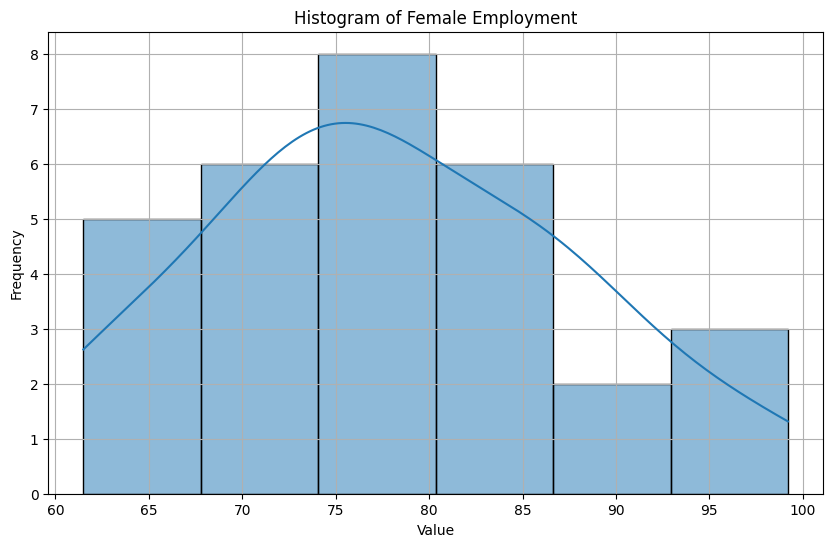

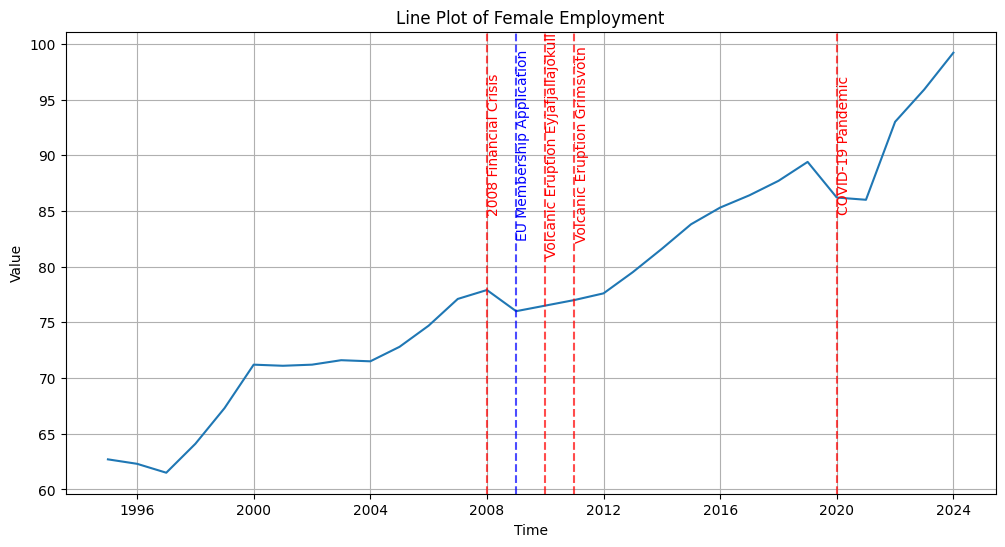

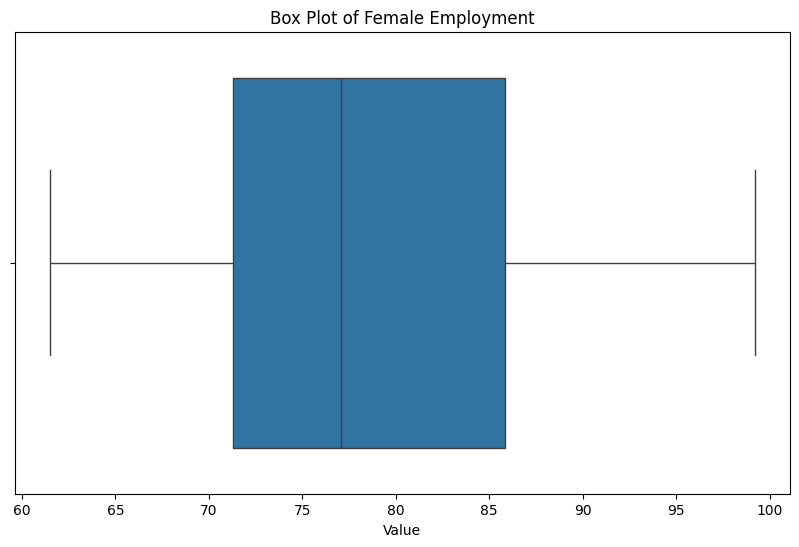

,unit,sex,age,citizen,time,value
238,THS_PER,M,Y15-64,TOTAL,1995-01-01,69.9
857,THS_PER,M,Y15-64,TOTAL,1996-01-01,70.8
1476,THS_PER,M,Y15-64,TOTAL,1997-01-01,70.8
2095,THS_PER,M,Y15-64,TOTAL,1998-01-01,73.5
2714,THS_PER,M,Y15-64,TOTAL,1999-01-01,76.3


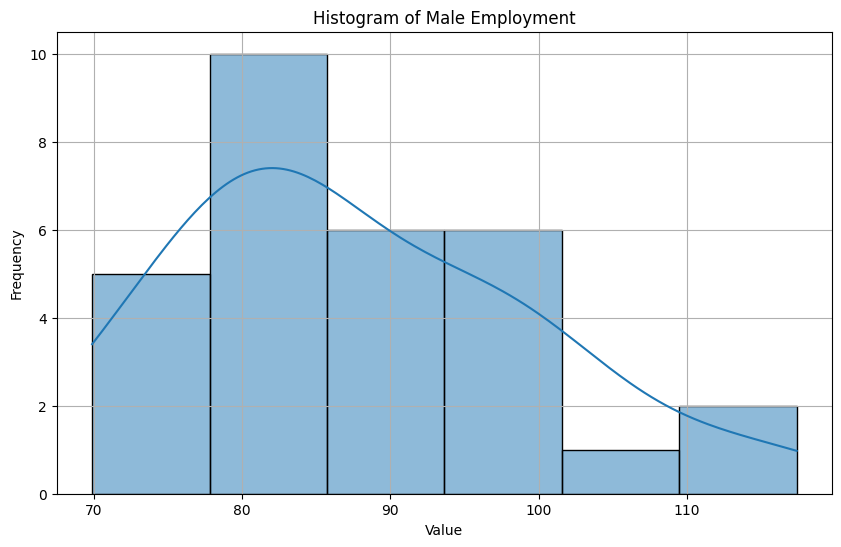

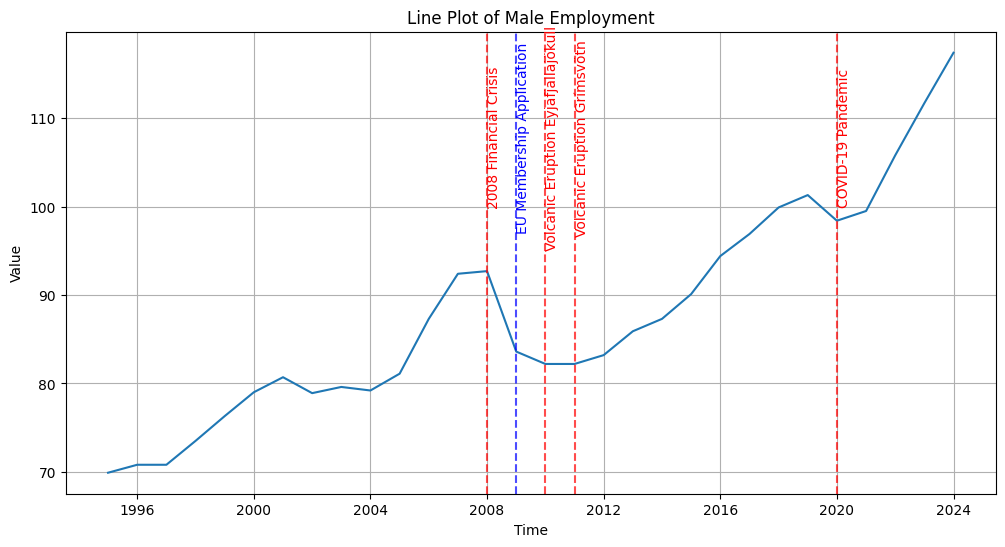

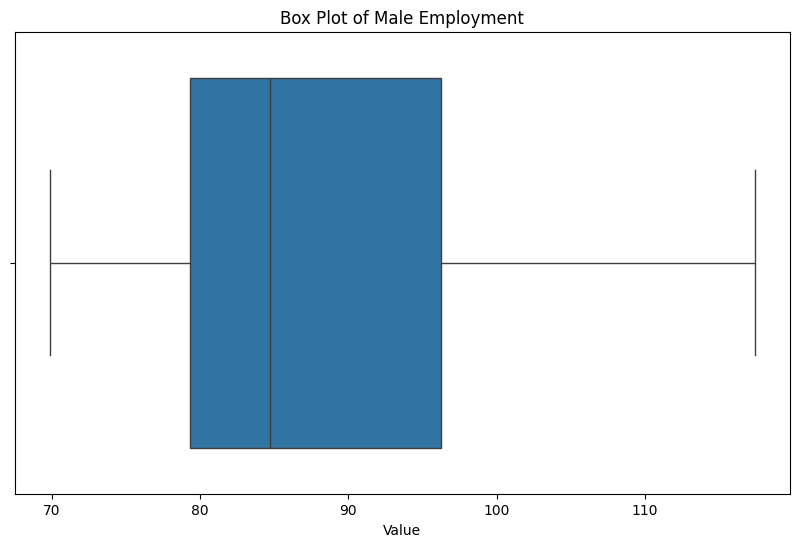

,unit,sex,age,citizen,time,value
439,THS_PER,T,Y15-64,TOTAL,1995-01-01,132.5
1058,THS_PER,T,Y15-64,TOTAL,1996-01-01,133.0
1677,THS_PER,T,Y15-64,TOTAL,1997-01-01,132.2
2296,THS_PER,T,Y15-64,TOTAL,1998-01-01,137.7
2915,THS_PER,T,Y15-64,TOTAL,1999-01-01,143.7


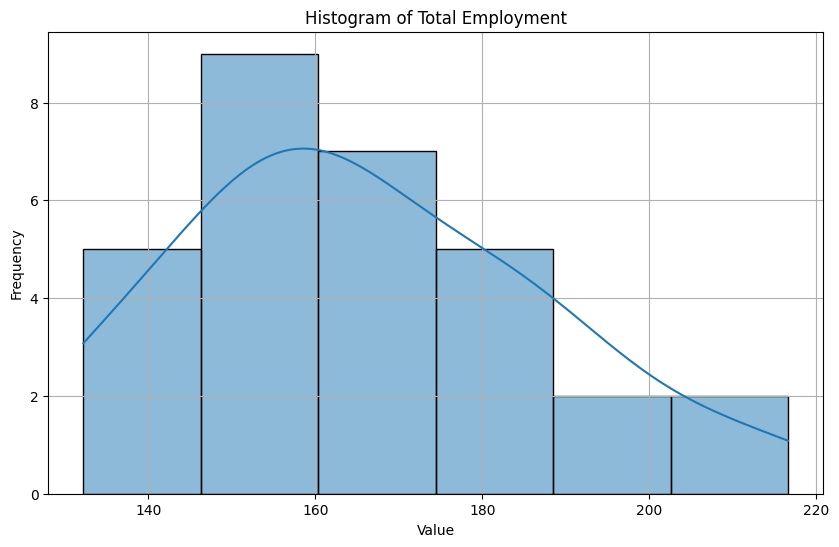

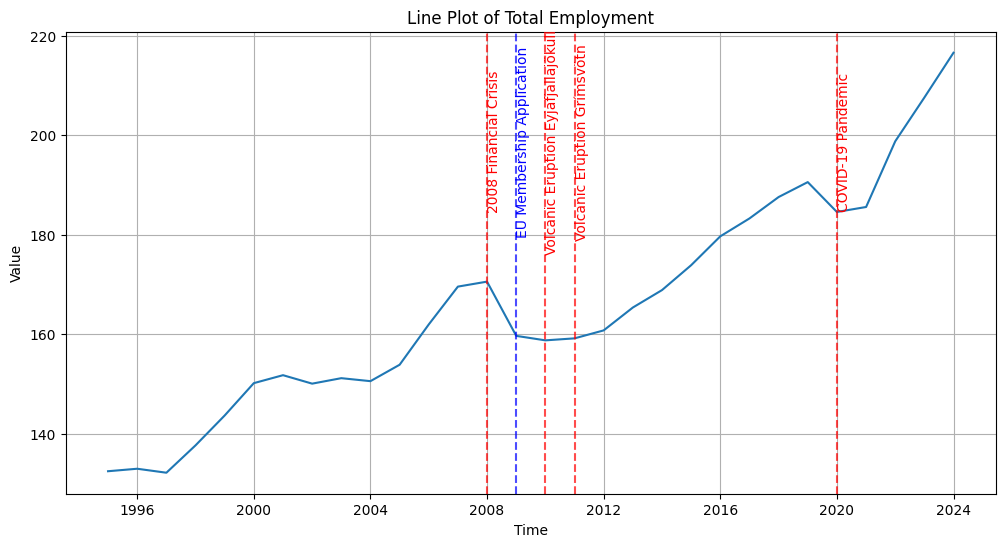

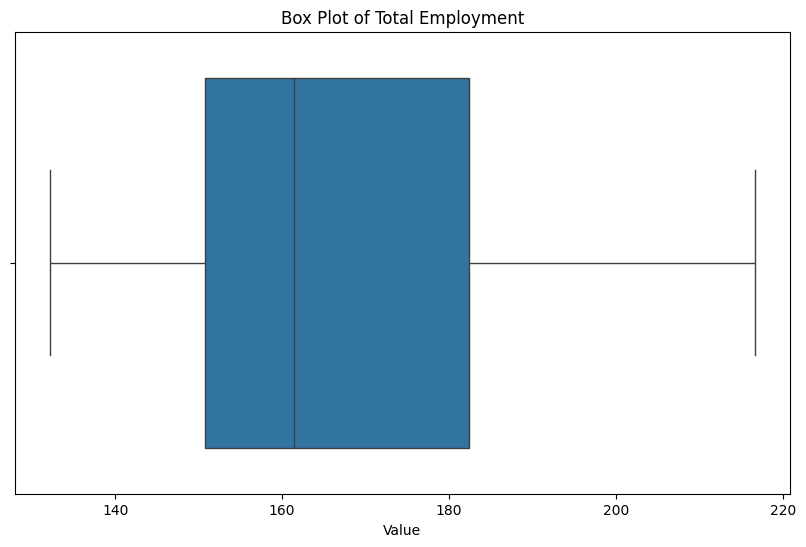

In [847]:
lfsa_egan = get_dataframe("lfsa_egan")
lfsa_egan = fix_dates(lfsa_egan)
lfsa_egan = remove_empty_columns(lfsa_egan)
lfsa_egan = melt_dataframe(lfsa_egan)
lfsa_egan = drop_columns(lfsa_egan, ["freq"])

lfsa_egan_f = filter_dataframe(lfsa_egan, {"unit": ["THS_PER"], "age": ["Y15-64"], "sex": ["F"], "citizen": ["TOTAL"]})
lfsa_egan_f.name = "lfsa_egan_f"
lfsa_egan_f.title = "Female Employment"
display(lfsa_egan_f.head())
make_histogram(lfsa_egan_f).show()
make_line_plot(lfsa_egan_f).show()
# make_scatter_plot(lfsa_egan_f).show()
make_box_plot(lfsa_egan_f).show()

lfsa_egan_m = filter_dataframe(lfsa_egan, {"unit": ["THS_PER"], "age": ["Y15-64"], "sex": ["M"], "citizen": ["TOTAL"]})
lfsa_egan_m.name = "lfsa_egan_m"
lfsa_egan_m.title = "Male Employment"
display(lfsa_egan_m.head())
make_histogram(lfsa_egan_m).show()
make_line_plot(lfsa_egan_m).show()
# make_scatter_plot(lfsa_egan_m).show()
make_box_plot(lfsa_egan_m).show()

lfsa_egan_t = filter_dataframe(lfsa_egan, {"unit": ["THS_PER"], "age": ["Y15-64"], "sex": ["T"], "citizen": ["TOTAL"]})
lfsa_egan_t.name = "lfsa_egan_t"
lfsa_egan_t.title = "Total Employment"
display(lfsa_egan_t.head())
make_histogram(lfsa_egan_t).show()
make_line_plot(lfsa_egan_t).show()
# make_scatter_plot(lfsa_egan_t).show()
make_box_plot(lfsa_egan_t).show()



### earn_nt_gpgr2 -- Annual Gender Pay Gap in Unadjusted Form

`B-S_X_O` - Industry, construction and services (except public administration, defense, compulsory social security)


,unit,nace_r2,time,value
2,PC,B-S_X_O,2007-01-01,24.0
17,PC,B-S_X_O,2008-01-01,20.7
32,PC,B-S_X_O,2009-01-01,18.0
47,PC,B-S_X_O,2010-01-01,17.7
62,PC,B-S_X_O,2011-01-01,17.8


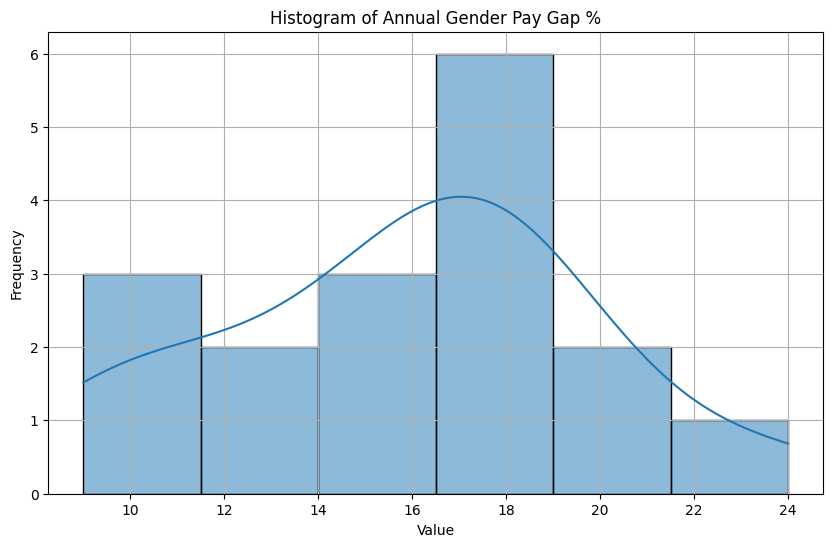

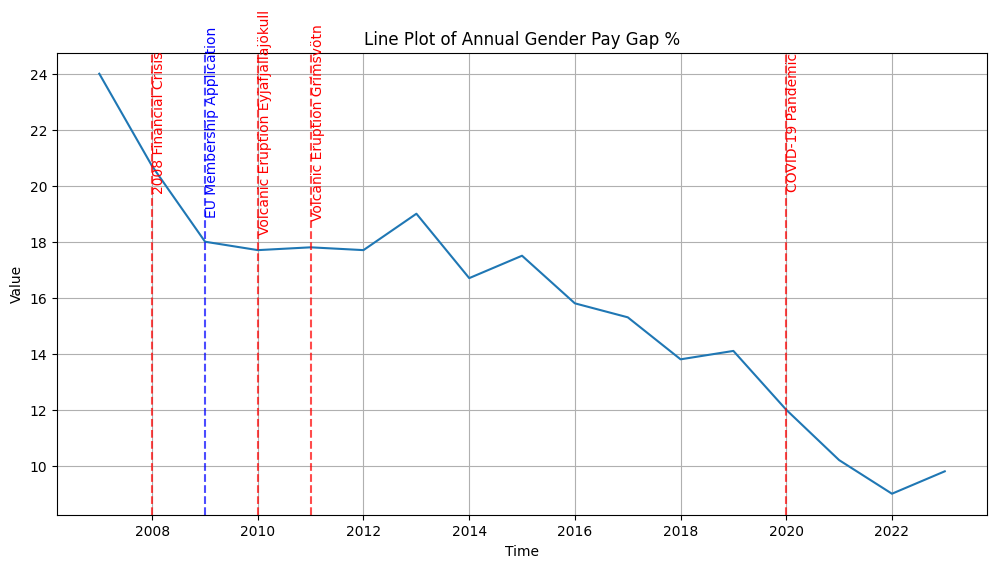

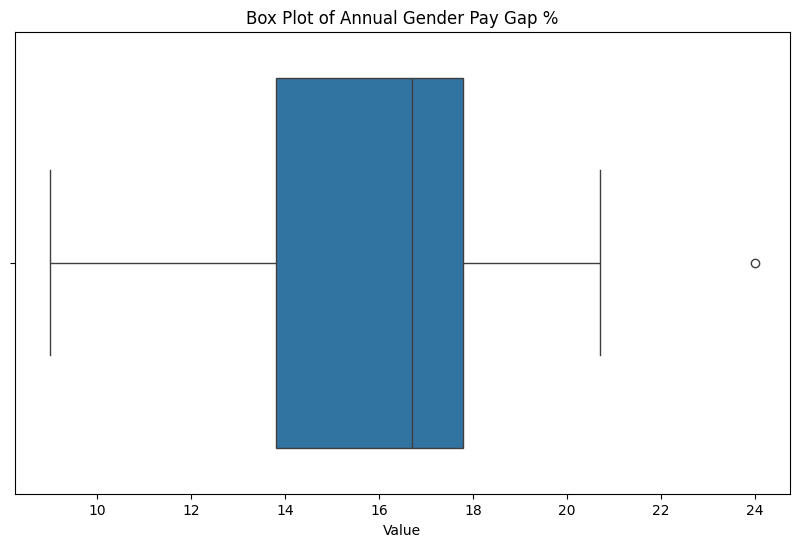

In [848]:
earn_nt_gpgr2 = get_dataframe("earn_gr_gpgr2")
earn_nt_gpgr2 = fix_dates(earn_nt_gpgr2)
earn_nt_gpgr2 = remove_empty_columns(earn_nt_gpgr2)
earn_nt_gpgr2 = melt_dataframe(earn_nt_gpgr2)
earn_nt_gpgr2 = drop_columns(earn_nt_gpgr2, ["freq"])
earn_nt_gpgr2 = filter_dataframe(earn_nt_gpgr2, {"nace_r2": ["B-S_X_O"]})
earn_nt_gpgr2.name = "earn_nt_gpgr2"
earn_nt_gpgr2.title = "Annual Gender Pay Gap %"

display(earn_nt_gpgr2.head())
make_histogram(earn_nt_gpgr2).show()
make_line_plot(earn_nt_gpgr2).show()
# make_scatter_plot(earn_nt_gpgr2).show()
make_box_plot(earn_nt_gpgr2).show()

### earn_nt_net -- Annual Net Earnings

`EUR` - Euro

`P1_NCH_AW50` - Single person without children earning 50% of the average earning

`NET` - Net


,currency,estruct,ecase,time,value
36,EUR,NET,P1_NCH_AW50,2000-01-01,15915.98
270,EUR,NET,P1_NCH_AW50,2001-01-01,14361.76
504,EUR,NET,P1_NCH_AW50,2002-01-01,15049.54
738,EUR,NET,P1_NCH_AW50,2003-01-01,15863.70
972,EUR,NET,P1_NCH_AW50,2004-01-01,16726.50


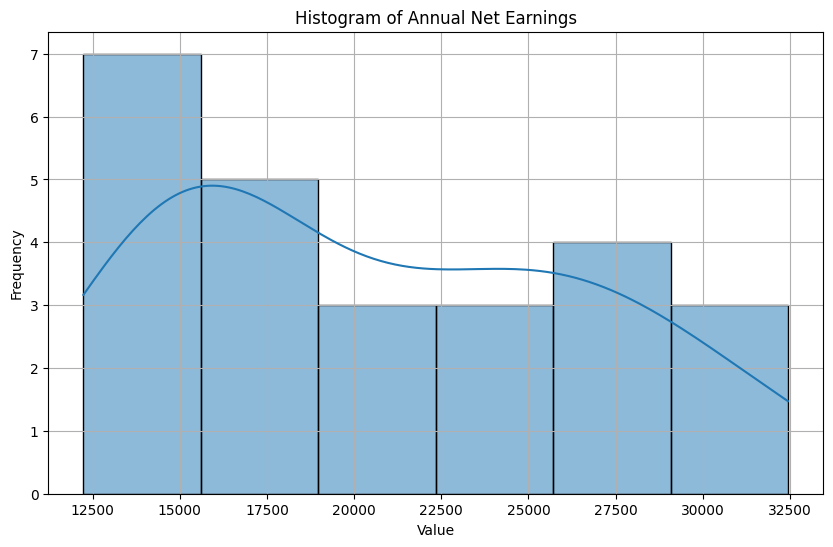

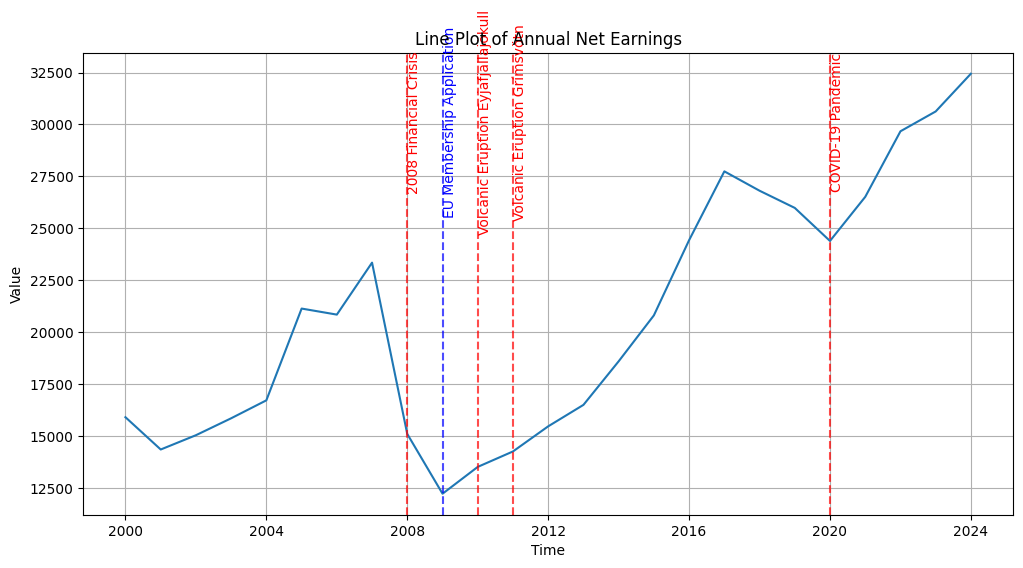

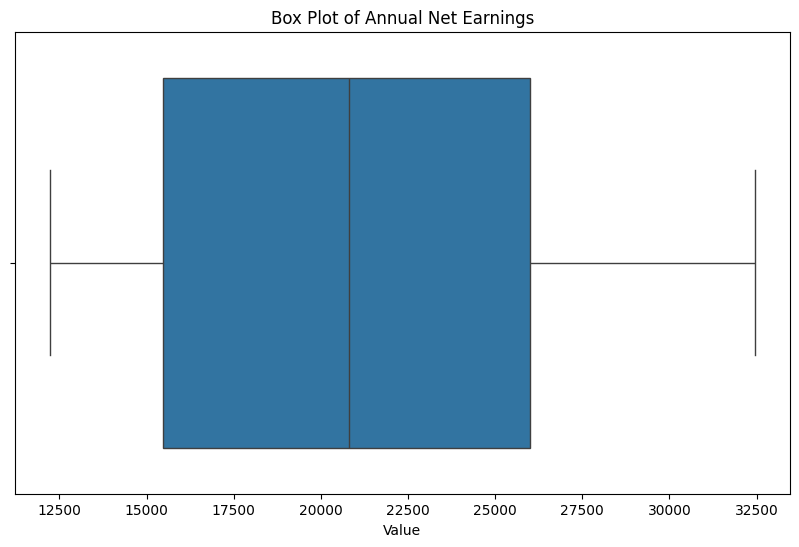

In [849]:
earn_nt_net = get_dataframe("earn_nt_net")
earn_nt_net = fix_dates(earn_nt_net)
earn_nt_net = remove_empty_columns(earn_nt_net)
earn_nt_net = melt_dataframe(earn_nt_net)
earn_nt_net = drop_columns(earn_nt_net, ["freq"])
earn_nt_net = filter_dataframe(earn_nt_net, {"currency": ["EUR"], "ecase": ["P1_NCH_AW50"], "estruct": ["NET"]})
earn_nt_net.name = "earn_nt_net"
earn_nt_net.title = "Annual Net Earnings"

display(earn_nt_net.head())
make_histogram(earn_nt_net).show()
make_line_plot(earn_nt_net).show()
# make_scatter_plot(earn_nt_net).show()
make_box_plot(earn_nt_net).show()

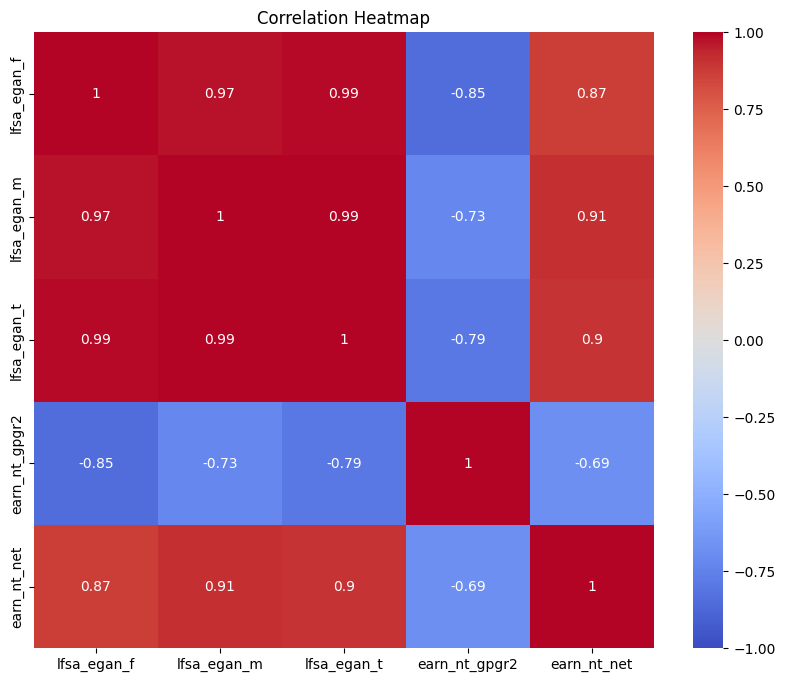

In [850]:
make_correlation_heatmap([
    lfsa_egan_f,
    lfsa_egan_m,
    lfsa_egan_t,
    earn_nt_gpgr2,
    earn_nt_net
]).show()

/var/folders/8c/03xsdbzx3wq49kn89_v3ggp40000gp/T/ipykernel_78989/1075503542.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_employment_l["time"] = pd.to_datetime(combined_df_employment_l["time"])


,time,value_earnings,value_paygap,empl_female,empl_male,income_f,income_m,income_diff
0,2007-01-01,23352.58,24.0,77.1,92.4,20550.27,26154.89,5604.62
1,2008-01-01,15112.17,20.7,77.9,92.7,13548.06,16676.28,3128.22
2,2009-01-01,12234.29,18.0,76.0,83.6,11133.20,13335.38,2202.18
3,2010-01-01,13525.15,17.7,76.5,82.2,12328.17,14722.13,2393.96
4,2011-01-01,14267.79,17.8,77.0,82.2,12997.96,15537.62,2539.66


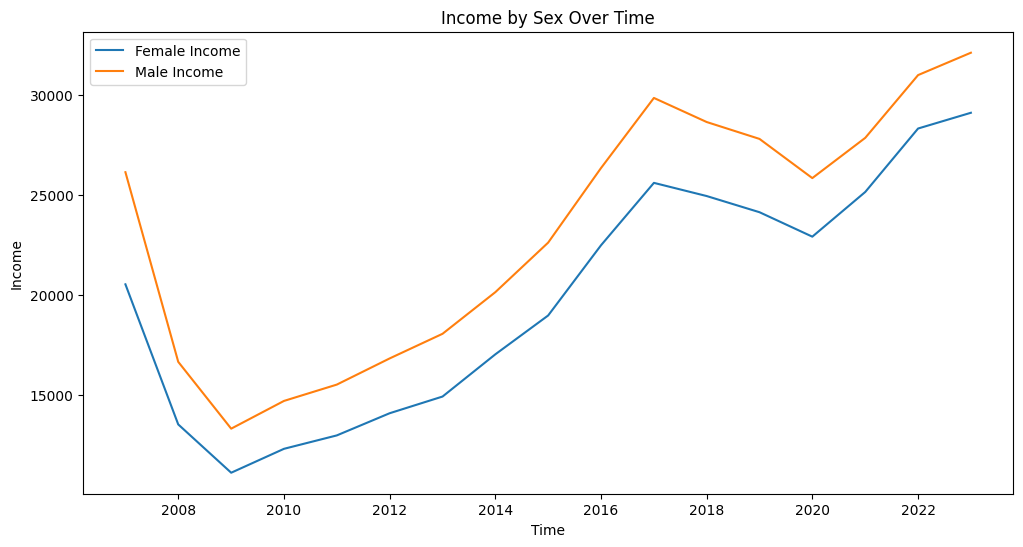

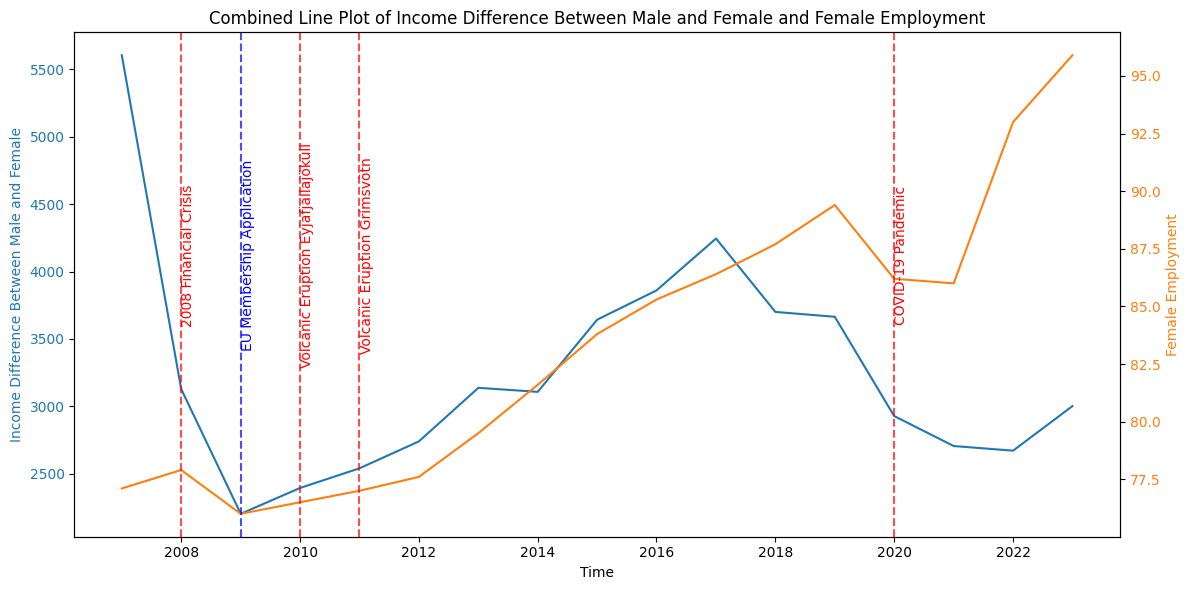

'Correlation Coefficient between Income Difference and Female Employment: 0.06752938329299765'

'Correlation Coefficient between Income Difference and Female Employment (from 2017): -0.32805023145123635'

In [859]:
combined_df = pd.merge(
    earn_nt_net,
    earn_nt_gpgr2,
    on="time",
    suffixes=("_earnings", "_paygap")
)
combined_df = combined_df[["time", "value_earnings", "value_paygap"]]
lfsa_egan_f["time"] = pd.to_datetime(lfsa_egan_f["time"])
lfsa_egan_m["time"] = pd.to_datetime(lfsa_egan_m["time"])
combined_df_employment = pd.merge(
    lfsa_egan_f.rename(columns={"value": "empl_female"}),
    lfsa_egan_m.rename(columns={"value": "empl_male"}),
    on="time"
)
combined_df_employment_l = combined_df_employment[["time", "empl_female", "empl_male"]]

combined_df["time"] = pd.to_datetime(combined_df["time"])
combined_df_employment_l["time"] = pd.to_datetime(combined_df_employment_l["time"])

combined_df = pd.merge(
    combined_df,
    combined_df_employment_l,
    on="time"
)

# get the income by sex using fromula:
# income_f = earnings * (1 - paygap / 100 / 2) * employment_f / employment_m
# income_m = earnings * (1 + paygap / 100 / 2) * employment_m / employment_f
# combined_df["income_f"] = (combined_df["value_earnings"] * (1 - combined_df["value_paygap"] / 100 / 2) * combined_df["empl_female"] / combined_df["empl_male"]).round(2)
# combined_df["income_m"] = (combined_df["value_earnings"] * (1 + combined_df["value_paygap"] / 100 / 2) * combined_df["empl_male"] / combined_df["empl_female"]).round(2)
combined_df["income_f"] = (combined_df["value_earnings"] * (1 - combined_df["value_paygap"] / 100 / 2)).round(2)
combined_df["income_m"] = (combined_df["value_earnings"] * (1 + combined_df["value_paygap"] / 100 / 2)).round(2)
combined_df["income_diff"] = (combined_df["income_m"] - combined_df["income_f"]).round(2)
display(combined_df.head())

combined_df["time"] = pd.to_datetime(combined_df["time"])

combined_df.name = "combined_employment_earnings_paygap"
combined_df.title = "Employment, Earnings and Pay Gap"

plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_df, x="time", y="income_f", label="Female Income")
sns.lineplot(data=combined_df, x="time", y="income_m", label="Male Income")
plt.title("Income by Sex Over Time")
plt.xlabel("Time")
plt.ylabel("Income")
plt.legend()
plt.show()

difference_df = combined_df[["time", "income_diff"]].rename(columns={"income_diff": "value"})
difference_df["time"] = pd.to_datetime(difference_df["time"])
lfsa_egan_f["time"] = pd.to_datetime(lfsa_egan_f["time"])

start_date = max(difference_df["time"].min(), lfsa_egan_f["time"].min())
end_date = min(difference_df["time"].max(), lfsa_egan_f["time"].max())
difference_df_filtered = difference_df[
    (difference_df["time"] >= start_date) &
    (difference_df["time"] <= end_date)
]
lfsa_egan_f_filtered = lfsa_egan_f[
    (lfsa_egan_f["time"] >= start_date) &
    (lfsa_egan_f["time"] <= end_date)
]

lfsa_egan_f_filtered.name = "lfsa_egan_f_filtered"
lfsa_egan_f_filtered.title = "Female Employment"
difference_df_filtered.name = "income_difference"
difference_df_filtered.title = "Income Difference Between Male and Female"

make_combined_line_plot(
    difference_df_filtered,
    lfsa_egan_f_filtered
).show()

correlation_df = pd.merge(
    difference_df_filtered,
    lfsa_egan_f_filtered,
    on="time",
    suffixes=("_income_diff", "_female_employment")
)
correlation_coefficient = correlation_df["value_income_diff"].corr(correlation_df["value_female_employment"])
display(f"Correlation Coefficient between Income Difference and Female Employment: {correlation_coefficient}")

# correlation starting 2017
correlation_df_2017 = correlation_df[correlation_df["time"] >= pd.to_datetime("2017-01-01")]
correlation_coefficient_2017 = correlation_df_2017["value_income_diff"].corr(correlation_df_2017["value_female_employment"])
display(f"Correlation Coefficient between Income Difference and Female Employment (from 2017): {correlation_coefficient_2017}")


Conclusion: Overall, there is no significant correlation between the gender wage gap and female employment rates in Iceland, however, starting from 2017 there appears to be a moderate negative correlation with a coefficient of 32.8% (the results of which are heavily influenced by COVID-19 pandemic).